In [8]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


# Step-by-Step Detailed Overview of the Data Processing and Sentiment Analysis Workflow

This workflow consists of two main parts:
1. **Filtering and Saving Summaries with Minimum Character Requirement**
2. **Analyzing Sentiment and Merging with Movie Metadata**

## Part 1: Filtering and Saving Summaries with Minimum Character Requirement

### Step 1.1: Import Necessary Libraries
We start by importing the `pandas` library, which will be used for data manipulation, and Python's built-in file handling functionality.

### Step 1.2: Define File Paths
We specify the path to the `plot_summaries.txt` file (containing movie summaries) and define an output path where the filtered summaries will be saved in TSV format.

### Step 1.3: Filter Summaries with Sufficient Length
We open the `plot_summaries.txt` file and iterate through each line, which contains a movie's ID and its summary, separated by a tab. For each line:
- We try to split the line into `movie_id` and `summary`.
- We check if the summary has at least 1000 characters.
- If it does, we extract the last 400 characters and store them in a list `data`, paired with the `movie_id`.

If a line doesn't conform to the expected format, it's ignored, and a message is printed.

### Step 1.4: Save Filtered Data to a TSV File
Once all lines are processed, the filtered summaries are saved to a new TSV file (`filtered_plot_summaries_last_400_characters.tsv`) using `pandas.DataFrame`.

## Part 2: Analyzing Sentiment and Merging with Movie Metadata

### Step 2.1: Load Movie Metadata and Summary Files
We import the `textblob` library for sentiment analysis, and `pandas` for data processing.

### Step 2.2: Load Movie Metadata and Filtered Summaries
We load:
- The `movie.metadata.tsv` file, which contains information such as `Movie_ID`, `Title`, `Release_Date`, etc., while setting the `Movie_ID` column as a string for consistency.
- The `filtered_plot_summaries_last_400_characters.tsv` file created in Part 1, containing filtered summaries.

### Step 2.3: Define the Sentiment Analysis Function
Using `TextBlob`, we define a function to analyze sentiment polarity of each summary:
- A high positive polarity (> 0.5) corresponds to a "Very Happy Ending" (Score = 5).
- A moderate positive polarity (between 0.13 and 0.5) is a "Happy Ending" (Score = 4).
- A neutral polarity (between -0.13 and 0.13) is classified as "Neutral" (Score = 3).
- A moderate negative polarity (between -0.5 and -0.13) is labeled as a "Sad Ending" (Score = 2).
- A highly negative polarity (< -0.5) represents a "Very Sad Ending" (Score = 1).

### Step 2.4: Merge Metadata and Summary Data on Movie ID
We use an inner join to merge `movie_data` and `summaries_data` on the `Movie_ID` column, resulting in a combined dataset of only the movies that have both metadata and summaries.

### Step 2.5: Apply Sentiment Analysis
The `analyze_sentiment` function is applied to the `Summary` column of the merged dataset to generate a `Score` column, representing the sentiment score for each movie.

### Step 2.6: Save the Final Dataset
Finally, the combined dataset with sentiment scores is saved to a TSV file, `movies_dataset_w_scores.tsv`, for further analysis.


In [84]:
import pandas as pd

file_path = 'plot_summaries.txt'
output_file_path = 'filtered_plot_summaries_last_400_characters.tsv'
data = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            movie_id, summary = line.split('\t', 1)  
            summary = summary.strip()  
            
            if len(summary) >= 1000:
                last_400_characters = summary[-400:].strip()
                data.append({'Movie_ID': movie_id, 'Summary': last_400_characters})
                
        except ValueError:
            print(f"Ligne ignorée (mauvais format) : {line}")

df = pd.DataFrame(data)

df.to_csv(output_file_path, sep='\t', index=False)

print(f"Fichier TSV créé avec succès : {output_file_path}")


Fichier TSV créé avec succès : filtered_plot_summaries_last_400_characters.tsv


In [85]:
import pandas as pd
from textblob import TextBlob

metadata_path = 'movie.metadata.tsv'
movie_data = pd.read_csv(metadata_path, sep='\t', header=None, dtype={0: str})  # Charger l'ID comme chaîne
movie_data.columns = ['Movie_ID', 'Other_Column', 'Title', 'Release_Date', 'Revenue', 'Runtime', 'Languages', 'Country', 'Genres']

summaries_path = 'filtered_plot_summaries_last_300_characters.tsv'
summaries_data = pd.read_csv(summaries_path, sep='\t', dtype={'Movie_ID': str})

print("Premières lignes de movie_data :")
print(movie_data.head())

print("Premières lignes de summaries_data :")
print(summaries_data.head())

def analyze_sentiment(summary):
    analysis = TextBlob(summary)
    polarity = analysis.sentiment.polarity
    if polarity > 0.5:
        return 5  # Very happy ending
    elif 0.13 < polarity <= 0.5:
        return 4  # Happy ending
    elif -0.13 <= polarity <= 0.13:
        return 3  # Neutral ending
    elif -0.5 < polarity < -0.13:
        return 2  # Sad ending
    else:
        return 1  # Very sad ending

merged_data = pd.merge(movie_data, summaries_data, on='Movie_ID', how='inner')

print(f"Nombre de films avec correspondance : {len(merged_data)}")

merged_data['Score'] = merged_data['Summary'].apply(analyze_sentiment)

output_file_path = 'movies_dataset_w_scores.tsv'
merged_data.to_csv(output_file_path, sep='\t', index=False)

print(f"Dataset avec scores sauvegardé dans {output_file_path}")


Premières lignes de movie_data :
   Movie_ID Other_Column                                              Title  \
0    975900    /m/03vyhn                                     Ghosts of Mars   
1   3196793    /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
2  28463795   /m/0crgdbh                                        Brun bitter   
3   9363483   /m/0285_cd                                   White Of The Eye   
4    261236    /m/01mrr1                                  A Woman in Flames   

  Release_Date     Revenue  Runtime                           Languages  \
0   2001-08-24  14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1   2000-02-16         NaN     95.0  {"/m/02h40lc": "English Language"}   
2         1988         NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3         1987         NaN    110.0  {"/m/02h40lc": "English Language"}   
4         1983         NaN    106.0   {"/m/04306rv": "German Language"}   

                                     Coun

In [ ]:
import requests
from tqdm import tqdm
import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

# API Key and Base URL setup
API_KEY = '9923aaa2a3b2777bfdeba7f76c97d212'
BASE_SEARCH_URL = 'https://api.themoviedb.org/3/search/movie'
BASE_MOVIE_URL = 'https://api.themoviedb.org/3/movie'

# Load the existing movie dataset
file_path = 'movies_dataset_w_scores.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

# Define function to fetch movie data from TMDB API
def get_movie_data_from_tmdb(wikipedia_id, title):
    params = {
        'api_key': API_KEY,
        'query': title,
        'language': 'en-US'
    }
    response = requests.get(BASE_SEARCH_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['results']:
            movie_data = data['results'][0]
            overview = movie_data.get('overview', '')
            tmdb_id = movie_data.get('id', None)
            return wikipedia_id, {"overview": overview, "tmdb_id": tmdb_id}
    print(f"Error fetching data for {title} (ID {wikipedia_id}): {response.status_code}")
    return wikipedia_id, {}
# Define functions to get specific movie details and credits
def get_movie_details(wikipedia_id, tmdb_id):
    response = requests.get(f"{BASE_MOVIE_URL}/{tmdb_id}", params={'api_key': API_KEY, 'language': 'en-US'})
    return (wikipedia_id, "details", response.json()) if response.status_code == 200 else (wikipedia_id, "details", {})

def get_movie_credits(wikipedia_id, tmdb_id):
    response = requests.get(f"{BASE_MOVIE_URL}/{tmdb_id}/credits", params={'api_key': API_KEY})
    return (wikipedia_id, "credits", response.json()) if response.status_code == 200 else (wikipedia_id, "credits", {})

# Load existing TMDB data if available
DATA_FOLDER = '.'
if os.path.exists(f'{DATA_FOLDER}/movie_data_from_tmdb.pkl'):
    with open(f'{DATA_FOLDER}/movie_data_from_tmdb.pkl', 'rb') as file:
        movie_data_from_tmdb = pickle.load(file)
else:
    movie_data_from_tmdb = {}

# Fetch missing TMDB data
movies_to_process = [
    (wiki_id, title) for wiki_id, title in zip(movies_df['Other_Column'], movies_df['Title'])
    if wiki_id not in movie_data_from_tmdb
]
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(get_movie_data_from_tmdb, movie_id, title): movie_id for movie_id, title in movies_to_process}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching TMDB IDs"):
        wikipedia_id, movie_info = future.result()
        if movie_info:
            movie_data_from_tmdb[wikipedia_id] = movie_info


Fetching TMDB IDs:   7%|▋         | 34/473 [00:00<00:02, 168.50it/s]

Error fetching data for Purab Aur Paschim (ID /m/0czmpz): 200Error fetching data for Alaskan Nights (ID /m/0j63snv): 200
Error fetching data for The Seinfeld Chronicles (ID /m/066j_j): 200
Error fetching data for The Angels Wash Their Faces (ID /m/027nccj): 200

Error fetching data for Cozy Dens (ID /m/043qglw): 200
Error fetching data for Tere Ghar ke Saamne (ID /m/0djsk0): 200
Error fetching data for Anbirkku Alavillai (ID /m/0b77n5c): 200
Error fetching data for Anbu Thozhi (ID /m/0523t_1): 200
Error fetching data for Mehndi Waley Hath (ID /m/02w5vj3): 200
Error fetching data for Aga Bai Arrecha (ID /m/03d96ht): 200
Error fetching data for Achamundu Achamundu (ID /m/03whngr): 200
Error fetching data for Sadhu Babar Lathi (ID /m/04z_gr1): 200
Error fetching data for Naato Raa (ID /m/09g7v7z): 200
Error fetching data for Missing Without Leave (ID /m/043k94f): 200
Error fetching data for Chaithanya (ID /m/0dlkwgt): 200
Error fetching data for Iga no Kabamaru (ID /m/0kv6vf): 200
Error f

Fetching TMDB IDs:  14%|█▍        | 67/473 [00:00<00:02, 138.26it/s]

Error fetching data for Jayam Manade Raa (ID /m/0kt_sz): 200Error fetching data for On The Nameless Height (ID /m/0d1mph): 200

Error fetching data for Patnam Vachina Pativrathalu (ID /m/09k7fry): 200
Error fetching data for 30 Days of Night: Blood Trails (ID /m/03d4p25): 200
Error fetching data for Nirom (ID /m/04n5n6z): 200
Error fetching data for Jau Tithe Khau (ID /m/05mxb3_): 200
Error fetching data for Two and half letters of Love (ID /m/0288xkc): 200
Error fetching data for Bitters and Blue Ruin (ID /m/077vh8): 200
Error fetching data for Mahamantri Timmarusu (ID /m/07s9x5y): 200
Error fetching data for The Incredible Mightiest vs. Mightiest (ID /m/06pnn_): 200
Error fetching data for Bionicle: Mask of Light: The Movie (ID /m/072pht): 200
Error fetching data for Objection/Hatred (ID /m/0822cv): 200
Error fetching data for Firestarter 2: Rekindled (ID /m/0dcy7s): 200
Error fetching data for Soaappu Seeppu Kannadi (ID /m/0h7qprb): 200
Error fetching data for Meenaxi: A Tale of Thr

Fetching TMDB IDs:  23%|██▎       | 108/473 [00:00<00:02, 162.03it/s]

Error fetching data for Elven Bride (ID /m/0blb_9): 200
Error fetching data for Aadalat (ID /m/02qkcv7): 200
Error fetching data for I Step through Moscow (ID /m/07_2y6): 200
Error fetching data for About Red Cap (ID /m/0gmctnn): 200
Error fetching data for Salaam E Ishq: A Tribute To Love (ID /m/09lgg5): 200
Error fetching data for Larki Panjaban (ID /m/0c6v5z): 200
Error fetching data for Poramboku (ID /m/02831n2): 200
Error fetching data for Kana Kandaen (ID /m/03wc1nl): 200
Error fetching data for Dragon Fist Explosion!! If Gokū Can't Do It, Who Will? (ID /m/068qkb): 200
Error fetching data for I G Inspector General (ID /m/0bh9cb4): 200
Error fetching data for An Unfinished Letter (ID /m/080kwh1): 200
Error fetching data for Abahoman (ID /m/0b74168): 200
Error fetching data for Ananda Tandavam (ID /m/03qlhr9): 200
Error fetching data for Agaradhi (ID /m/0kv7gm): 200
Error fetching data for Kitty Foyle: The Natural History of a Woman (ID /m/02qsqb2): 200
Error fetching data for Nokk

Fetching TMDB IDs:  26%|██▋       | 125/473 [00:00<00:02, 142.20it/s]

Error fetching data for Uppalawanna (ID /m/0crg8kk): 200
Error fetching data for Kandam Bacha Kotte (ID /m/080kr78): 200
Error fetching data for Dharam Aur Kanoon (ID /m/0c414tz): 200
Error fetching data for A Story That Begins at the End (ID /m/09g6633): 200
Error fetching data for Masti: Sanam Teri Kasam (ID /m/080mt0): 200
Error fetching data for Gamma Squad (ID /m/0fp0n7): 200
Error fetching data for Rakkilippattu (ID /m/0gh8hgh): 200
Error fetching data for Angala parameswari (ID /m/064nnlt): 200
Error fetching data for A Game for Vultures (ID /m/03d8mf7): 200
Error fetching data for Aadu Kalam (ID /m/05c4p5y): 200
Error fetching data for Ran Salu (ID /m/03d5s84): 200
Error fetching data for Series 7: The Contenders (ID /m/05rm56): 200
Error fetching data for Swarna Kamalam (ID /m/02phdl_): 200
Error fetching data for Mini Moni Ja Movie: Okashina Daibouken (ID /m/0gg475): 200
Error fetching data for Jeevana Mukthi (ID /m/0hhqsmb): 200
Error fetching data for Manodu (ID /m/02rvh0d)

Fetching TMDB IDs:  35%|███▍      | 164/473 [00:01<00:01, 164.77it/s]

Error fetching data for Women on the Edge of a Nervous Breakdown (ID /m/04m6vj): 200
Error fetching data for Rakht: What If You Can See the Future (ID /m/026qm7m): 200
Error fetching data for Hridoyer Bandhon (ID /m/0gls5c4): 200
Error fetching data for Junior Creative (ID /m/02844xb): 200
Error fetching data for Tara Rum Pam Pam (ID /m/0f1qlg): 200
Error fetching data for Tara Rum Pam Pam (ID /m/0f1qlg): 200
Error fetching data for Baby Cakes (ID /m/0ddbhjj): 200
Error fetching data for Damon's Law (ID /m/080p3t5): 200
Error fetching data for Zay El Naharda (ID /m/04q8cst): 200
Error fetching data for The Goodies Rule – O.K.? (ID /m/026h9gw): 200
Error fetching data for A Lonesome, Final Battle: The Father of Z-Warrior Son Gokū, who Challenged Freeza (ID /m/03z48l): 200
Error fetching data for The Creators Documentary (ID /m/0gyv1c_): 200
Error fetching data for Antar Mahal (ID /m/0bsjk2): 200
Error fetching data for Her Right to Live (ID /m/03qn1xj): 200
Error fetching data for Bomba

Fetching TMDB IDs:  43%|████▎     | 204/473 [00:01<00:01, 163.91it/s]

Error fetching data for Dunya and Desi (ID /m/04jjwq5): 200
Error fetching data for Lupin the Third: The Movie - Lupin vs. the Clones (ID /m/06r8q9): 200
Error fetching data for Dunya and Desi (ID /m/04jjwq5): 200
Error fetching data for Deewane Huye Pagal (ID /m/090yk5): 200
Error fetching data for The Power of Nightmares (ID /m/04946n): 200
Error fetching data for The Power of Nightmares (ID /m/04946n): 200
Error fetching data for D'Lucky Ones (ID /m/0b74phs): 200
Error fetching data for Kasthoorimann (ID /m/03mfrd7): 200
Error fetching data for Kastoori Nivasa (ID /m/0dsjqf): 200
Error fetching data for Being Osama (ID /m/08gl96): 200
Error fetching data for Bangaaradha Manushya (ID /m/06ljvz): 200
Error fetching data for Piya Ka Ghar (ID /m/0gwl08): 200
Error fetching data for The Aqua Teen Hunger Force Movie Film for Theatres (ID /m/0ghsh1): 200
Error fetching data for Do It For Johnny (ID /m/040651x): 200
Error fetching data for Steptoe and Son (ID /m/027j29_): 200
Error fetching

Fetching TMDB IDs:  52%|█████▏    | 244/473 [00:01<00:01, 166.82it/s]

Error fetching data for Balram vs. Taradas (ID /m/02w8__s): 200
Error fetching data for Sluzhebnyi Roman (ID /m/0gqsxq): 200
Error fetching data for Jhanak Jhanak Payal Baje (ID /m/0fjqgf): 200
Error fetching data for The Crown of the Russian Empire/Once again the Elusive Avengers (ID /m/02x3b43): 200
Error fetching data for A Pure Country Gift (ID /m/0cc6j0r): 200
Error fetching data for Meravanige (ID /m/04gv8w1): 200
Error fetching data for Ishq Unplugged (ID /m/05q776v): 200
Error fetching data for Banaras - A Mystic Love Story (ID /m/027g54f): 200
Error fetching data for Shake, Rattle and Roll 2k5 (ID /m/026__4x): 200
Error fetching data for Boris and Natasha: The Movie (ID /m/03hzgd): 200
Error fetching data for Confrontation at Concordia (ID /m/02q1t16): 200
Error fetching data for Parenni Maya Jalaima (ID /m/02qnnr4): 200
Error fetching data for Uchū Senkan Yamato: Fukkatsu hen (ID /m/06_wws1): 200
Error fetching data for Parenni Maya Jalaima (ID /m/02qnnr4): 200
Error fetching

Fetching TMDB IDs:  55%|█████▌    | 262/473 [00:01<00:01, 170.30it/s]

Error fetching data for Khuda Ke Liye (ID /m/06r0nd): 200
Error fetching data for Khuda Ke Liye (ID /m/06r0nd): 200
Error fetching data for Puppet Master Vs The Demonic Toys (ID /m/0h7594): 200
Error fetching data for Queen Emeraldas (ID /m/02l6_b): 200
Error fetching data for 7aam Arivu (ID /m/0bxzdnf): 200
Error fetching data for Thamiraparani (ID /m/0gcwkp): 200
Error fetching data for Yokai Monsters: Vol. 1: Spook Warfare (ID /m/0cry2td): 200
Error fetching data for Centered in the Universe (ID /m/02rh3m2): 200
Error fetching data for Santhosha Subramani (ID /m/02rsb59): 200
Error fetching data for The Last Assyrians (ID /m/0gg924_): 200
Error fetching data for Thelomeris (ID /m/0gx0mdt): 200
Error fetching data for Case Closed: Strategy Above the Depths (ID /m/02rknss): 200
Error fetching data for Main Aur Mrs Khanna (ID /m/03wj9rz): 200
Error fetching data for You Must Be Scared (ID /m/0d5w2q): 200
Error fetching data for Ekjon Jhumur (ID /m/07kb9r8): 200
Error fetching data for 

Fetching TMDB IDs:  63%|██████▎   | 296/473 [00:01<00:01, 143.86it/s]

Error fetching data for The Occult History of the Third Reich (ID /m/025yjv2): 200Error fetching data for Ettupatti Rasa (ID /m/0j_6bxr): 200

Error fetching data for Charas: A Joint Operation (ID /m/05p3g3d): 200
Error fetching data for Gypsy Magic (ID /m/04cv7r0): 200
Error fetching data for Nirmalayam (ID /m/05zw0b0): 200
Error fetching data for Odour of Chrysanthemums (ID /m/03ckxwl): 200
Error fetching data for Kuch Meetha Ho Jaaye (ID /m/041361g): 200
Error fetching data for El Lute: Run for Your Life (ID /m/02vljd_): 200
Error fetching data for Do Bigha Zameen (ID /m/021zrr): 200
Error fetching data for Corso: The Last Beat (ID /m/03cnfqk): 200
Error fetching data for Corso: The Last Beat (ID /m/03cnfqk): 200
Error fetching data for Corso: The Last Beat (ID /m/03cnfqk): 200
Error fetching data for Thaaikkuppin Thaaram (ID /m/04gw4zh): 200
Error fetching data for Porky's Five and Ten (ID /m/0j9q1jw): 200
Error fetching data for Stranded: NxE1ufragos (ID /m/03ym0h6): 200
Error fet

Fetching TMDB IDs:  73%|███████▎  | 343/473 [00:02<00:00, 182.88it/s]

Error fetching data for Abelay Garam Bhaat (ID /m/04mx2qv): 200
Error fetching data for The 10th Kingdom (ID /m/042j6p): 200
Error fetching data for Rathi Nirvedam (ID /m/05q8hx7): 200
Error fetching data for The Texas Vibrator Massacre (ID /m/0k2hqdq): 200
Error fetching data for Azhagesan (ID /m/0jt7h6v): 200
Error fetching data for X-Rated: The TV They Tried to Ban (ID /m/02q6fx4): 200
Error fetching data for Northwest Mounted Police (ID /m/02wcb15): 200
Error fetching data for Kambakth Ishq (ID /m/04czjj_): 200
Error fetching data for Northwest Mounted Police (ID /m/02wcb15): 200
Error fetching data for Hariharnagar-2 (ID /m/04yg49b): 200
Error fetching data for Zameer: The Fire Within (ID /m/05b51n5): 200
Error fetching data for Everest '82 (ID /m/0g9tkv): 200
Error fetching data for Embrace Me Tightly (ID /m/02rx0mx): 200
Error fetching data for Attack of the 5 Ft. 2 In. Women (ID /m/05b3qzd): 200
Error fetching data for Aaptha Rakshaka (ID /m/080hx9f): 200
Error fetching data fo

Fetching TMDB IDs:  82%|████████▏ | 386/473 [00:02<00:00, 189.78it/s]

Error fetching data for Naruto the Movie 2: Great Clash! The Illusionary Ruins at the Depths of the Earth (ID /m/05pyrb): 200
Error fetching data for Sengoku Jieitai 1549 (ID /m/0bqbtc): 200
Error fetching data for Gaon Hamara Shaher Tumhara (ID /m/0521tkn): 200
Error fetching data for Thirumal Perumai (ID /m/04lj311): 200
Error fetching data for Shri Krishna Pandaviyam (ID /m/04m_61b): 200
Error fetching data for Stonewall & Riot: The Ultimate Orgasm (ID /m/02q9243): 200
Error fetching data for 9mm Sunrise (ID /m/0f2fxg): 200
Error fetching data for Agni Parvatam (ID /m/0b76jws): 200
Error fetching data for Blade of the Phantom Mask (ID /m/0g1h96): 200
Error fetching data for Blade of the Phantom Mask (ID /m/0g1h96): 200
Error fetching data for Star Wars: Revelations (ID /m/05zsyv): 200
Error fetching data for I Started Liking You (ID /m/0271k00): 200
Error fetching data for Jahan Tum Le Chalo (ID /m/05z_qj2): 200
Error fetching data for Suburban Legends: The Show (ID /m/04091gt): 200

Fetching TMDB IDs:  90%|█████████ | 428/473 [00:02<00:00, 198.68it/s]

Error fetching data for Ki Kore Bojhabo Tomake (ID /m/0j9qm8k): 200
Error fetching data for Barbie: The Princess and the Popstar (ID /m/0jwy_sz): 200
Error fetching data for Gharonda (ID /m/02qzhxc): 200
Error fetching data for Poor Little Rich Girl: The Barbara Hutton Story (ID /m/0kv9cc): 200
Error fetching data for Nadodikattu (ID /m/06_mqv): 200
Error fetching data for Vinashak - Destroyer (ID /m/047d2mz): 200
Error fetching data for Dust Devil: The Final Cut (ID /m/04j0vm8): 200
Error fetching data for The Mystery of the Marie Celeste (ID /m/0282w38): 200
Error fetching data for Dust Devil: The Final Cut (ID /m/04j0vm8): 200
Error fetching data for See Anthony Run (ID /m/0b6jndb): 200
Error fetching data for The New Shaolin Temple (ID /m/09rwym3): 200
Error fetching data for Noah's Arc: The Short Film (ID /m/0crdylr): 200
Error fetching data for The New Shaolin Temple (ID /m/09rwym3): 200
Error fetching data for Left Behind: The Movie (ID /m/09w_x_): 200
Error fetching data for Le

Fetching TMDB IDs:  95%|█████████▌| 451/473 [00:02<00:00, 207.47it/s]

Error fetching data for Return to Lonesome Dove (ID /m/03mc12_): 200Error fetching data for Anderusen Dowa Ningyo Hime (ID /m/02pjp09): 200

Error fetching data for Anderusen Dowa Ningyo Hime (ID /m/02pjp09): 200
Error fetching data for Anderusen Dowa Ningyo Hime (ID /m/02pjp09): 200
Error fetching data for Anderusen Dowa Ningyo Hime (ID /m/02pjp09): 200
Error fetching data for Tees Mar Khan (ID /m/0b6jrt_): 200
Error fetching data for Antaratama (ID /m/04m_0mg): 200
Error fetching data for Get Set Goal (ID /m/02r37f4): 200
Error fetching data for Get Set Goal (ID /m/02r37f4): 200
Error fetching data for Yamato Takeru (ID /m/03cc823): 200
Error fetching data for Yaadon Ki Baraat (ID /m/0c9v0j): 200
Error fetching data for Hitler's Grave (ID /m/09g7pj1): 200
Error fetching data for Noir Drive (ID /m/04_060p): 200
Error fetching data for Hitler's Grave (ID /m/09g7pj1): 200
Error fetching data for 5ive Days to Midnight (ID /m/02wvzhj): 200
Error fetching data for 5ive Days to Midnight (ID

Fetching TMDB IDs: 100%|██████████| 473/473 [00:03<00:00, 132.87it/s]

Error fetching data for Randaam Bhavam (ID /m/0cz841z): 200


In [ ]:
# Save basic data to avoid re-fetching
with open(f'{DATA_FOLDER}/movie_data_from_tmdb_only_id.pkl', 'wb') as file:
    pickle.dump(movie_data_from_tmdb, file)

# Fetch additional details and credits
movies_to_process = [(wiki_id, info['tmdb_id']) for wiki_id, info in movie_data_from_tmdb.items() if info.get('tmdb_id') and 'details' not in info]
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    for wiki_id, tmdb_id in movies_to_process:
        futures.append(executor.submit(get_movie_details, wiki_id, tmdb_id))
        futures.append(executor.submit(get_movie_credits, wiki_id, tmdb_id))
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching Details and Credits"):
        wikipedia_id, data_type, data = future.result()
        if wikipedia_id in movie_data_from_tmdb:
            movie_data_from_tmdb[wikipedia_id][data_type] = data

# Save the enriched TMDB data
with open(f'{DATA_FOLDER}/movie_data_from_tmdb.pkl', 'wb') as file:
    pickle.dump(movie_data_from_tmdb, file)

# Define helper functions for new data fields
def find_director(movie_data):
    crew = movie_data.get('credits', {}).get('crew', [])
    for person in crew:
        if person.get('job') == 'Director':
            return person.get('name', pd.NA)
    return pd.NA


def find_vote_average(movie_data):
    return movie_data.get('details', {}).get('vote_average', pd.NA)

def find_revenue(movie_data):
    return movie_data.get('details', {}).get('revenue', pd.NA)

# Map new data to the movies_df dataset
movies_df['director'] = movies_df['Other_Column'].map(lambda x: find_director(movie_data_from_tmdb.get(x, {})))
movies_df['vote_average'] = movies_df['Other_Column'].map(lambda x: find_vote_average(movie_data_from_tmdb.get(x, {})))
movies_df['revenue'] = movies_df['Other_Column'].map(lambda x: find_revenue(movie_data_from_tmdb.get(x, {})))
movies_df = movies_df.drop(columns=['Revenue', 'Movie_ID_y'], errors='ignore')

# Save the updated dataset back to the original file
movies_df.to_csv(file_path, sep='\t', index=False)
print(f"Updated dataset saved back to '{file_path}' with new columns: director, vote_average, and revenue")



Fetching Details and Credits: 0it [00:00, ?it/s]


Updated dataset saved back to 'movies_dataset_w_scores.tsv' with new columns: director, vote_average, and revenue


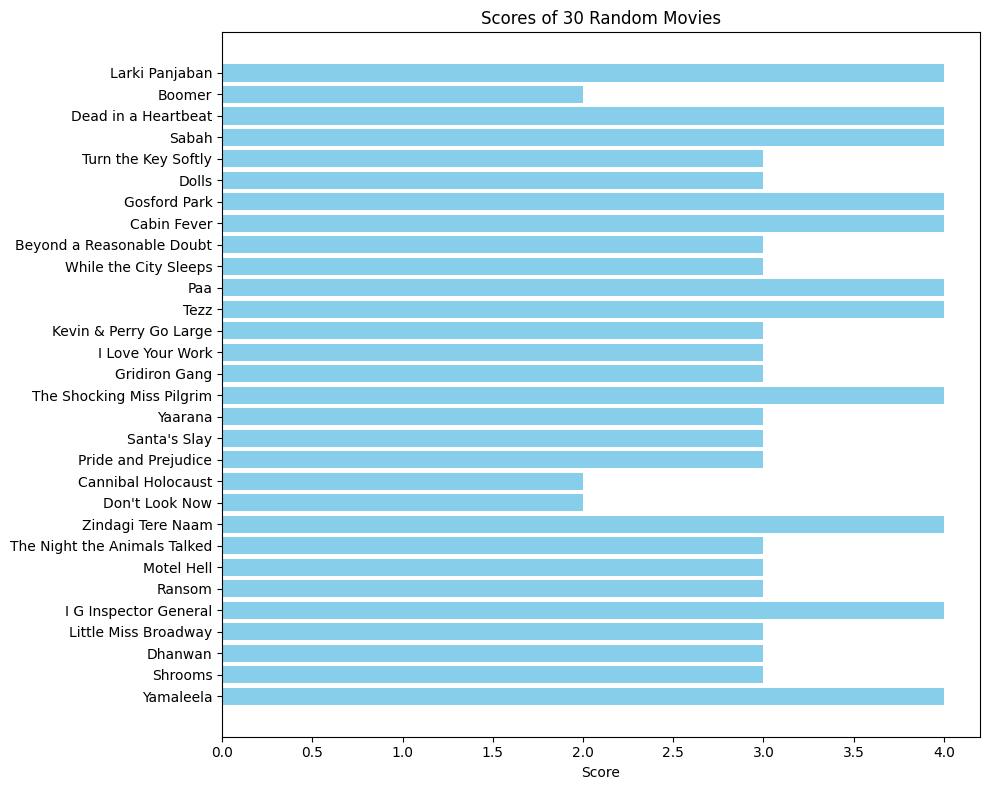

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'movies_dataset_w_scores.tsv'
movie_data = pd.read_csv(file_path, sep='\t')

sample_movies = movie_data.sample(n=30, random_state=42)

plt.figure(figsize=(10, 8))
plt.barh(sample_movies['Title'], sample_movies['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Scores of 30 Random Movies')
plt.gca().invert_yaxis()  #
plt.tight_layout()
plt.show()


### Code Explanation

This code calculates and adds the average age of characters per movie to the main movie dataset. Here is an outline of each step:

1. **Data Loading**: Load the main movie dataset (`movies_dataset_w_scores.tsv`) and the character dataset (`character.metadata.tsv`). The character dataset includes details like character name, birth date, and age.

2. **Data Preparation**: Convert the `Movie_ID` column in the character dataset and `Other_Column` in the movie dataset to string format to ensure compatibility for merging.

3. **Filter and Calculate Average Age**: Remove rows with missing ages in the character dataset, then calculate the average age of characters for each movie (`Movie_ID`). Round the result to two decimal places for readability.

4. **Merging the Average Age**: Merge the average age data into the main movie dataset by matching `Other_Column` (movie dataset) to `Movie_ID` (character dataset). Drop the extra `Movie_ID` column from the merged dataset to avoid redundancy.

5. **Saving the Updated Dataset**: Export the updated movie dataset, now containing the average character age per movie, to a new TSV file (`movies_dataset_w_scores_with_age.tsv`).

This code provides a quick way to integrate character age insights into the main movie dataset, enhancing analysis potential.


In [87]:
import pandas as pd

# Load the datasets of movies and characters
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')
characters_df = pd.read_csv('character.metadata.tsv', sep='\t', header=None, 
                            names=["Movie_ID", "Freebase_ID", "Release_Date", "Character_Name", 
                                   "Birth_Date", "Gender", "Height", "Actor_Name", "Age", 
                                   "Actor_Freebase_ID", "Character_Freebase_ID", "Actor_Character_Freebase_ID"])

# Ensure Movie_IDs are string types in both DataFrames
movies_df['Other_Column'] = movies_df['Other_Column'].astype(str)
characters_df['Movie_ID'] = characters_df['Movie_ID'].astype(str)

# Remove rows without 'Age' for accurate calculations
characters_df = characters_df.dropna(subset=['Age'])

# Calculate the average age for each Movie_ID
movie_age_stats = characters_df.groupby('Movie_ID').agg(
    Average_Age=('Age', 'mean')
).reset_index()

# Round the average age for better readability
movie_age_stats['Average_Age'] = movie_age_stats['Average_Age'].round(2)

# Display a sample of the calculated age statistics for verification
print("Sample age statistics for movies:")
print(movie_age_stats.head())

# Merge the calculated age statistics with the movies DataFrame, using 'Other_Column' to match 'Movie_ID'
movies_df = pd.merge(movies_df, movie_age_stats, left_on='Other_Column', right_on='Movie_ID', how='left')

# Check if 'Movie_ID' is present, then drop it to avoid KeyError
if 'Movie_ID' in movies_df.columns:
    movies_df = movies_df.drop(columns=['Movie_ID'])

# Save the updated dataset with the new 'Average_Age' column back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)

print("Dataset updated with average age and saved as 'movies_dataset_w_scores.tsv'")


Sample age statistics for movies:
    Movie_ID  Average_Age
0  /m/011_mj        20.00
1  /m/011_p6        21.00
2  /m/011_zy        25.00
3  /m/011wtv        36.89
4  /m/011x_4        37.60
Dataset updated with average age and saved as 'movies_dataset_w_scores.tsv'


### Code Explanation and Interpretation

This code segment calculates the correlation between two variables in the movie dataset (`movies_dataset_w_scores_with_stats.tsv`) and the movie score. Here’s a breakdown:

1. **Data Loading**: Load the dataset containing movie information, including average age of the cast, runtime, and score.

2. **Correlation Calculation**:
   - **Average Age vs. Score**: Compute the correlation between the average age of the movie's cast and the movie score. The result here is `0.00185`, indicating a negligible correlation. This suggests that the age of the cast members does not significantly impact or correlate with the movie's score.
   - **Runtime vs. Score**: Calculate the correlation between the movie runtime and the score, resulting in `-0.00198`. This low, near-zero negative correlation also suggests no meaningful relationship between a movie’s runtime and its score.

3. **Interpretation**:
   - Both results show that neither the average age of the cast nor the runtime of the movie has a strong or notable correlation with the movie's score. This implies that these factors likely don’t influence movie ratings, or at least that no consistent relationship exists in this dataset.
   
In summary, based on these correlations, there appears to be no significant impact of either cast age or runtime on movie scores.


In [88]:
import pandas as pd

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Calculate correlation between Average Age and Score
age_score_corr = movies_df['Average_Age'].corr(movies_df['Score'])
print(f"Correlation between Average Age of Cast and Movie Score: {age_score_corr}")

# Calculate correlation between Runtime and Score
runtime_score_corr = movies_df['Runtime'].corr(movies_df['Score'])
print(f"Correlation between Runtime of Movie and Movie Score: {runtime_score_corr}")


Correlation between Average Age of Cast and Movie Score: -0.0029186707758598373
Correlation between Runtime of Movie and Movie Score: -0.0019857974182977186


### Code Explanation and Interpretation

This code segment calculates the correlation between movie revenue and movie score, assessing whether there’s a meaningful relationship between a film’s financial success and its rating.

1. **Data Loading**: Load the dataset `movies_dataset_w_scores_with_stats.tsv` into a DataFrame.

2. **Data Preparation**:
   - **Revenue as Numeric**: Convert the `Revenue` column to a numeric type, setting non-numeric entries as NaN. This step ensures that only valid numeric values are used in the correlation calculation, which is crucial for obtaining accurate results.

3. **Correlation Calculation**:
   - Compute the correlation between `Revenue` and `Score`, yielding a result of `0.05`. This very low positive correlation indicates that revenue has almost no linear relationship with movie scores.

4. **Interpretation**:
   - A correlation of `0.05` suggests that higher or lower revenue is not consistently associated with higher or lower movie scores. Thus, in this dataset, revenue appears to be largely independent of movie ratings, and we can conclude that box office success doesn’t necessarily imply a high movie score.

In summary, based on this low correlation, there is no significant relationship between revenue and movie ratings.


In [89]:
import pandas as pd

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Ensure Revenue is numeric, replacing non-numeric values with NaN
movies_df['Revenue'] = pd.to_numeric(movies_df['Revenue'], errors='coerce')

# Calculate correlation between Revenue and Score
revenue_score_corr = movies_df[['Revenue', 'Score']].corr().iloc[0, 1]
print(f"Correlation between Revenue and Score: {revenue_score_corr:.2f}")


Correlation between Revenue and Score: 0.05


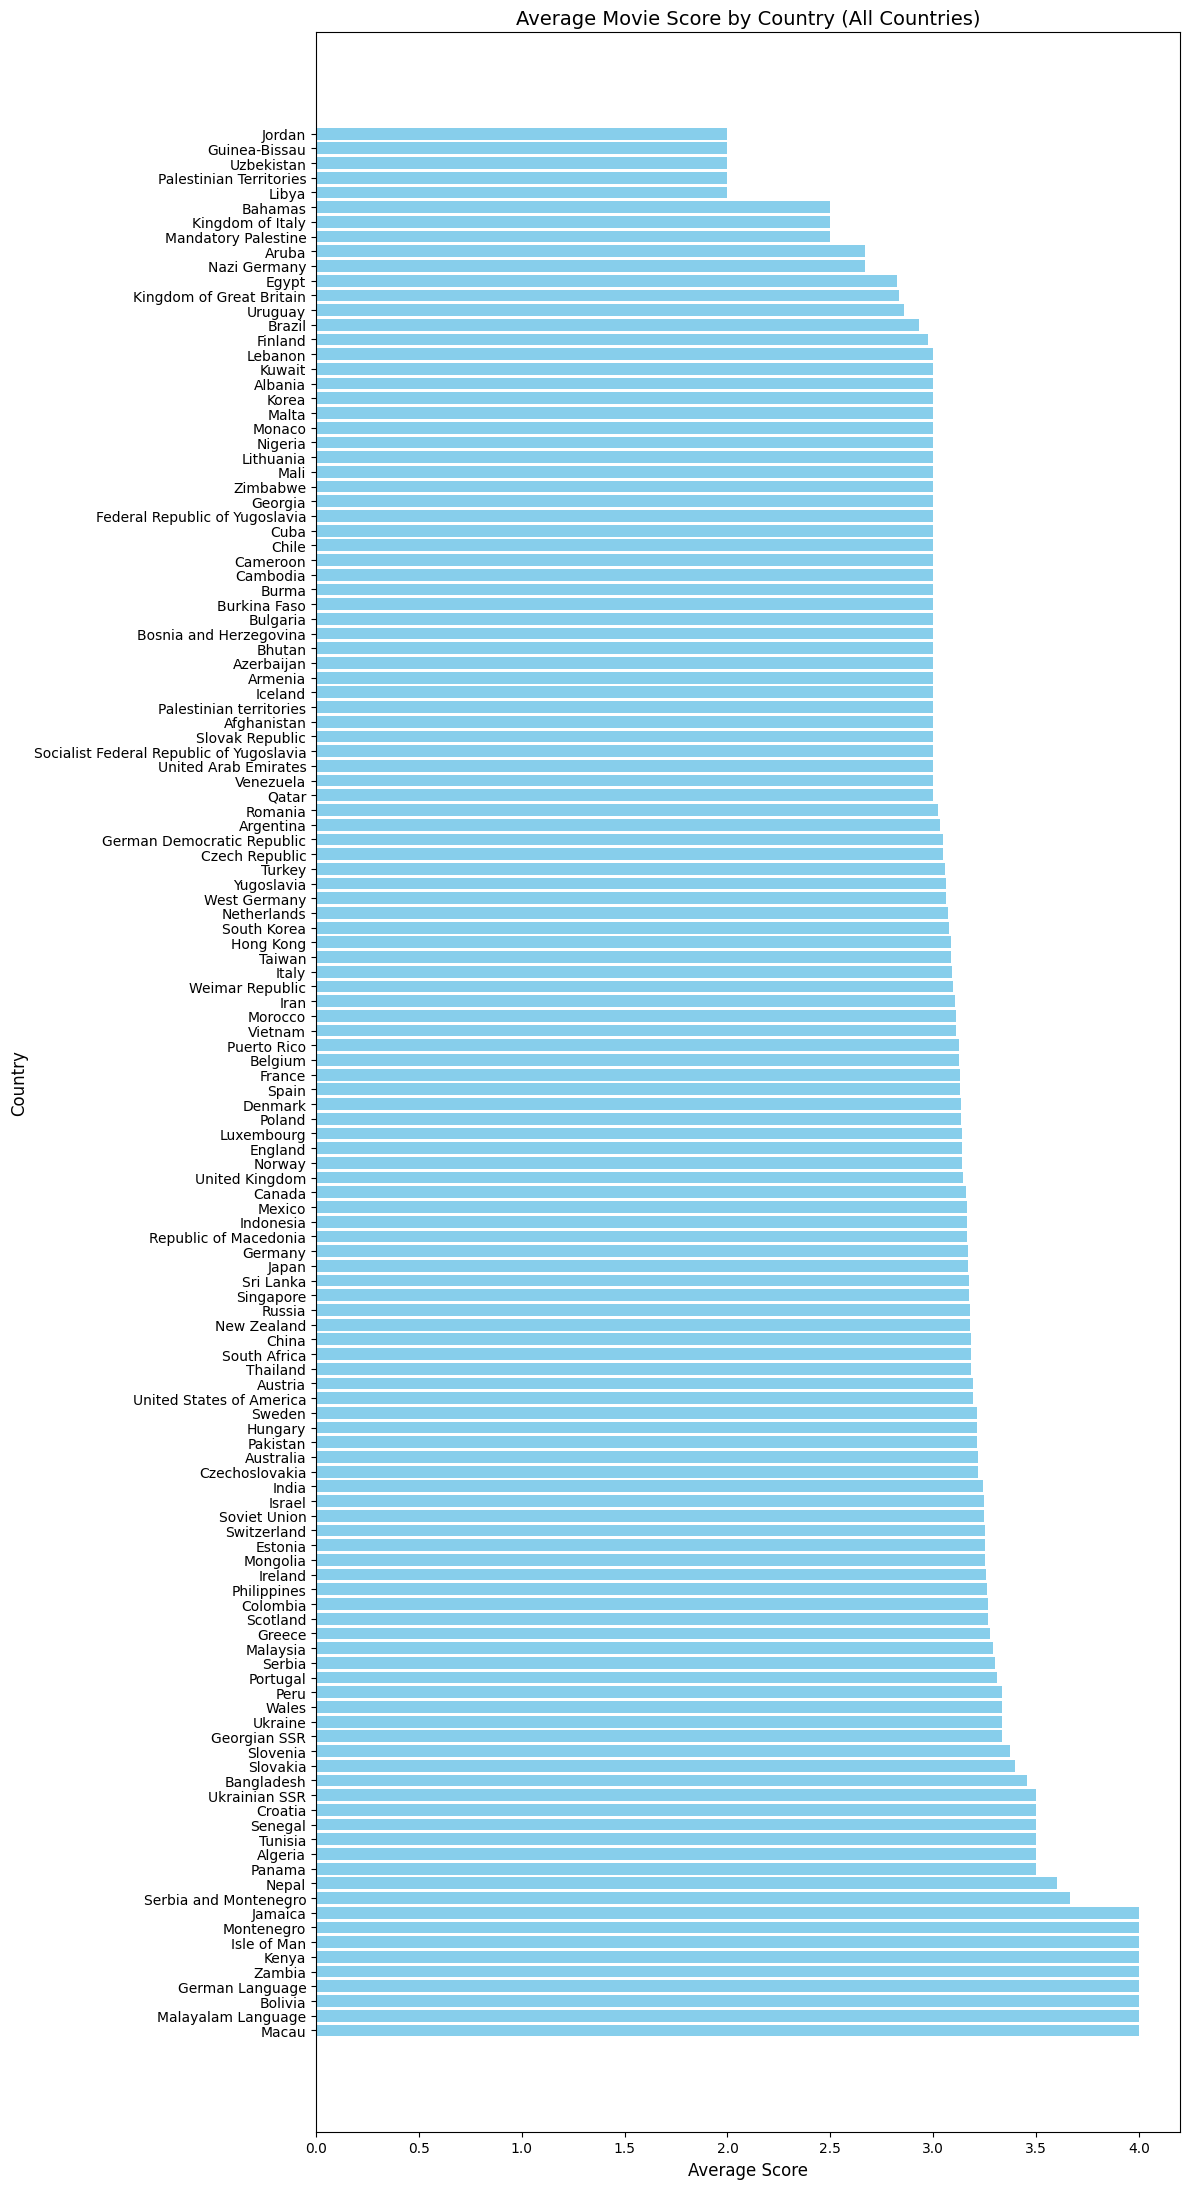

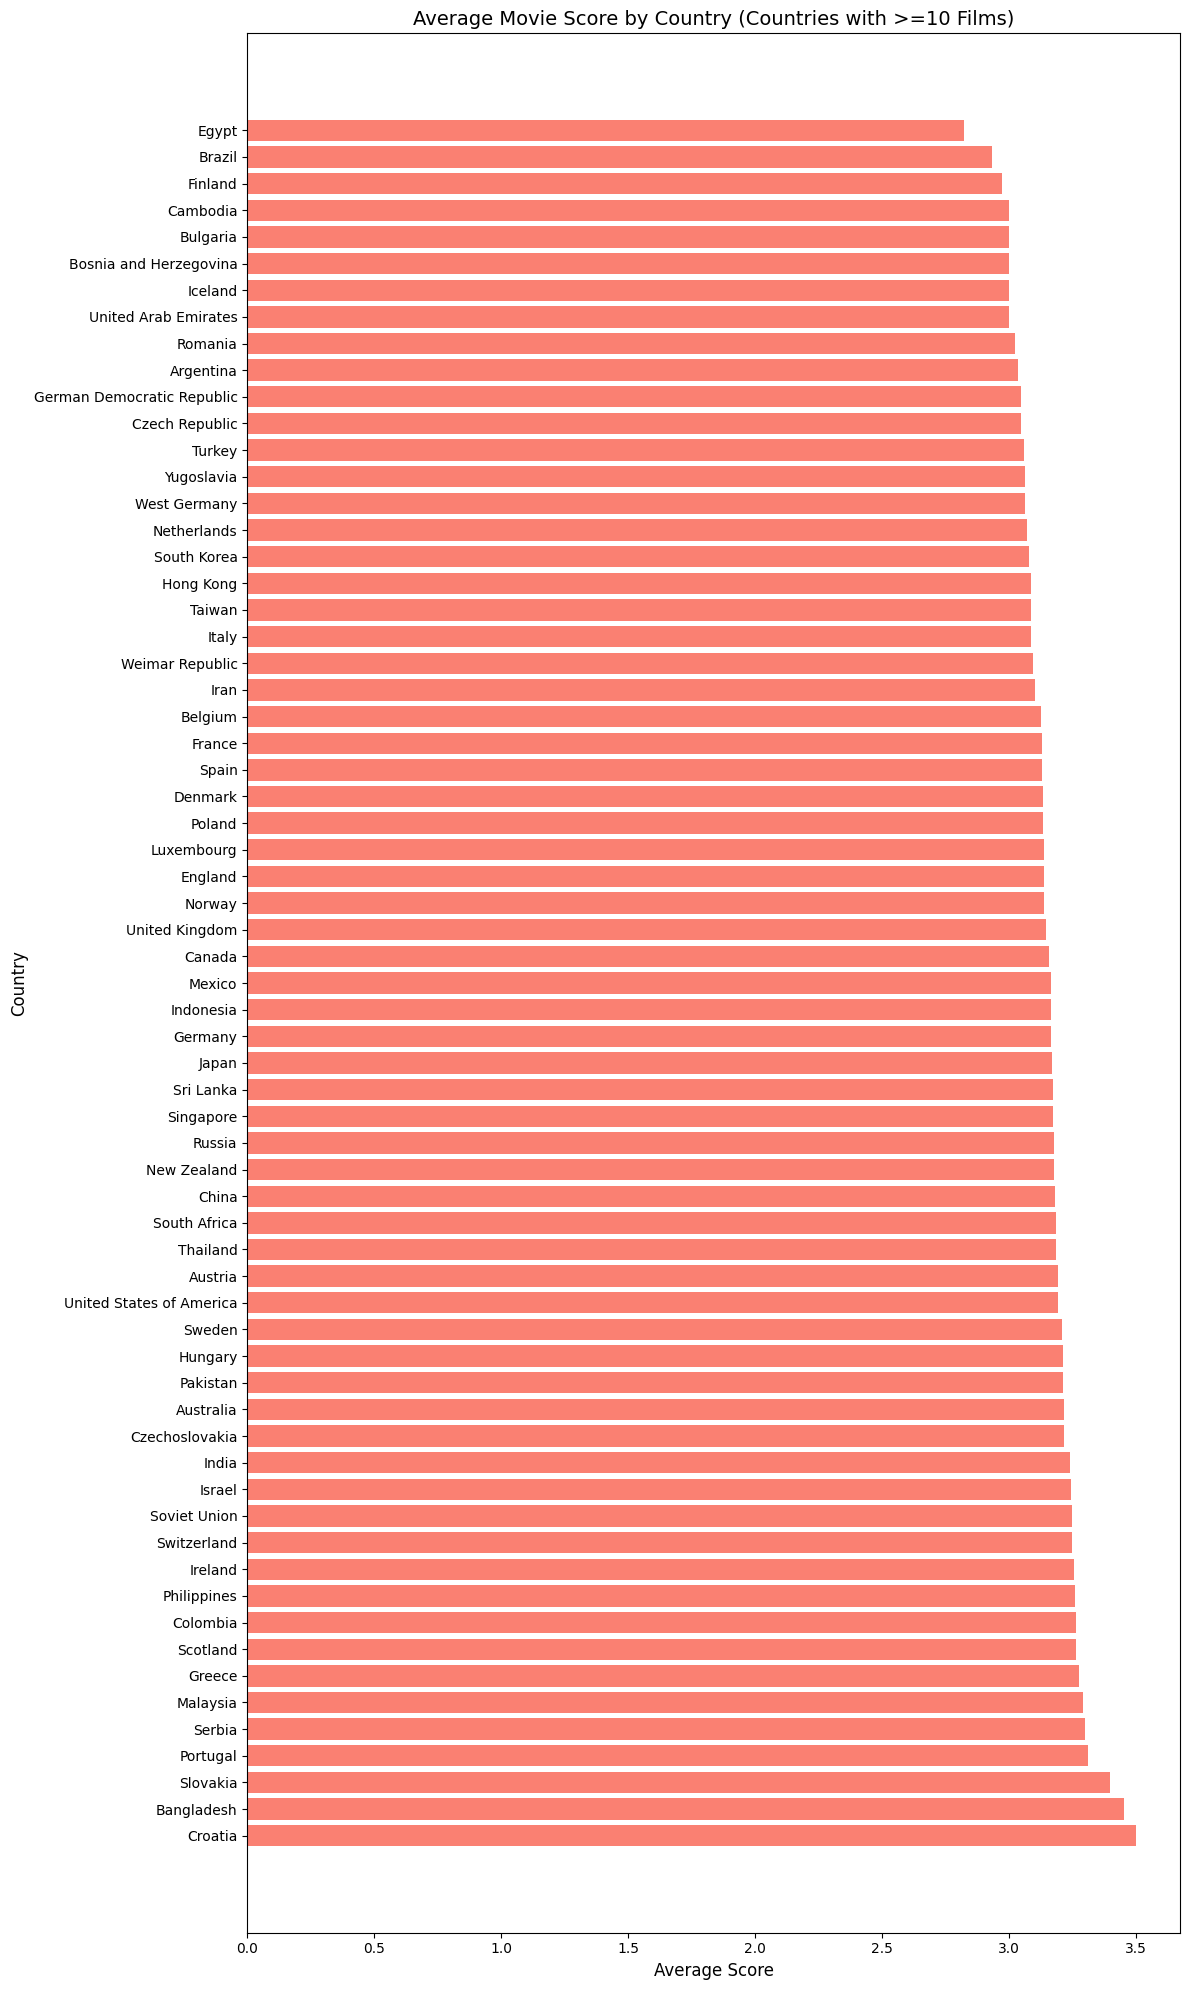

Dataset updated with cleaned 'Country' column and saved as 'movies_dataset_w_scores.tsv'


In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Helper function to clean up and extract country names
def extract_countries(country_data):
    if pd.isna(country_data) or '{' not in country_data:
        return None
    countries = []
    items = country_data.split(", ")
    for item in items:
        if ':' in item:
            country_name = item.split(":")[-1].strip().replace("\"", "").replace("}", "")
            countries.append(country_name)
    return ", ".join(countries) if countries else None

# Apply the function and overwrite the 'Country' column with cleaned country data
movies_df['Country'] = movies_df['Country'].apply(extract_countries)

# Drop rows with missing or invalid country data in 'Country'
movies_df = movies_df.dropna(subset=['Country']).copy()

# Explode the 'Country' column so each country has its own row
movies_df = movies_df.assign(Country=movies_df['Country'].str.split(", ")).explode('Country')

# Calculate average score and film count per country
country_stats = movies_df.groupby('Country').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter to get countries with at least 10 films
country_stats_10_plus = country_stats[country_stats['Film_Count'] >= 10]

# Plot for all countries
plt.figure(figsize=(12, 22))
plt.barh(country_stats.index, country_stats['Average_Score'], color='skyblue')
plt.ylabel('Country', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Country (All Countries)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot for countries with at least 10 films
plt.figure(figsize=(12, 20))
plt.barh(country_stats_10_plus.index, country_stats_10_plus['Average_Score'], color='salmon')
plt.ylabel('Country', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Country (Countries with >=10 Films)', fontsize=14)
plt.tight_layout()
plt.show()

# Save the updated dataset back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)
print("Dataset updated with cleaned 'Country' column and saved as 'movies_dataset_w_scores.tsv'")


# Analysis of Average Movie Scores by Language

In this section, we aim to clean the `Languages` column in our dataset, extract individual languages, and analyze the correlation between different languages and average movie scores. Here’s a breakdown of each step in the code:

### Step 1: Language Data Cleaning
We start by defining a helper function, `extract_languages`, that processes each entry in the `Languages` column to:
1. **Ignore Empty Values**: Skip entries where the `Languages` field is empty or formatted incorrectly.
2. **Extract and Clean Language Names**: Split each entry to isolate language names, remove both "Language" and "language" suffixes, and further strip away unwanted characters such as `"` and `}`.
3. **Filter by Length**: Only retain language names that are 40 characters or fewer, removing entries that are excessively long.

After cleaning, we overwrite the `Languages` column in the dataset with the cleaned data, ensuring only valid, well-formatted languages are retained.

### Step 2: Dropping Rows with Missing Language Data
We then drop any rows in which the `Languages` field is still empty after the cleaning process. This helps ensure our dataset is consistent and that each row has a valid language entry.

### Step 3: Saving the Cleaned Dataset
The cleaned dataset is saved to a new file, `movies_dataset_with_cleaned_languages.tsv`, allowing us to use it in further analyses without re-running the cleaning process.

### Step 4: Exploding the Languages Column
Using the `.explode()` function, we split the `Languages` column so that each language listed for a movie appears in its own row. This transformation enables us to group and analyze languages independently.

### Step 5: Calculating Average Score and Film Count per Language
After exploding the languages:
1. **Calculate Average Score**: We compute the average movie score for each language.
2. **Count Films**: We count the number of films associated with each language.

### Step 6: Filtering for Languages with Significant Representation
To improve the relevance of our analysis, we filter out languages that appear in fewer than 10 films, resulting in a separate dataset that focuses on languages with a more substantial number of films.

### Step 7: Visualization
Finally, we plot two bar graphs to visualize the results:
1. **All Languages**: Displays the average score for all languages.
2. **Languages with ≥10 Films**: Focuses on languages with at least 10 films in the dataset, allowing us to identify trends in languages with more data.

By examining these graphs, we can interpret potential differences in average movie scores across various languages.


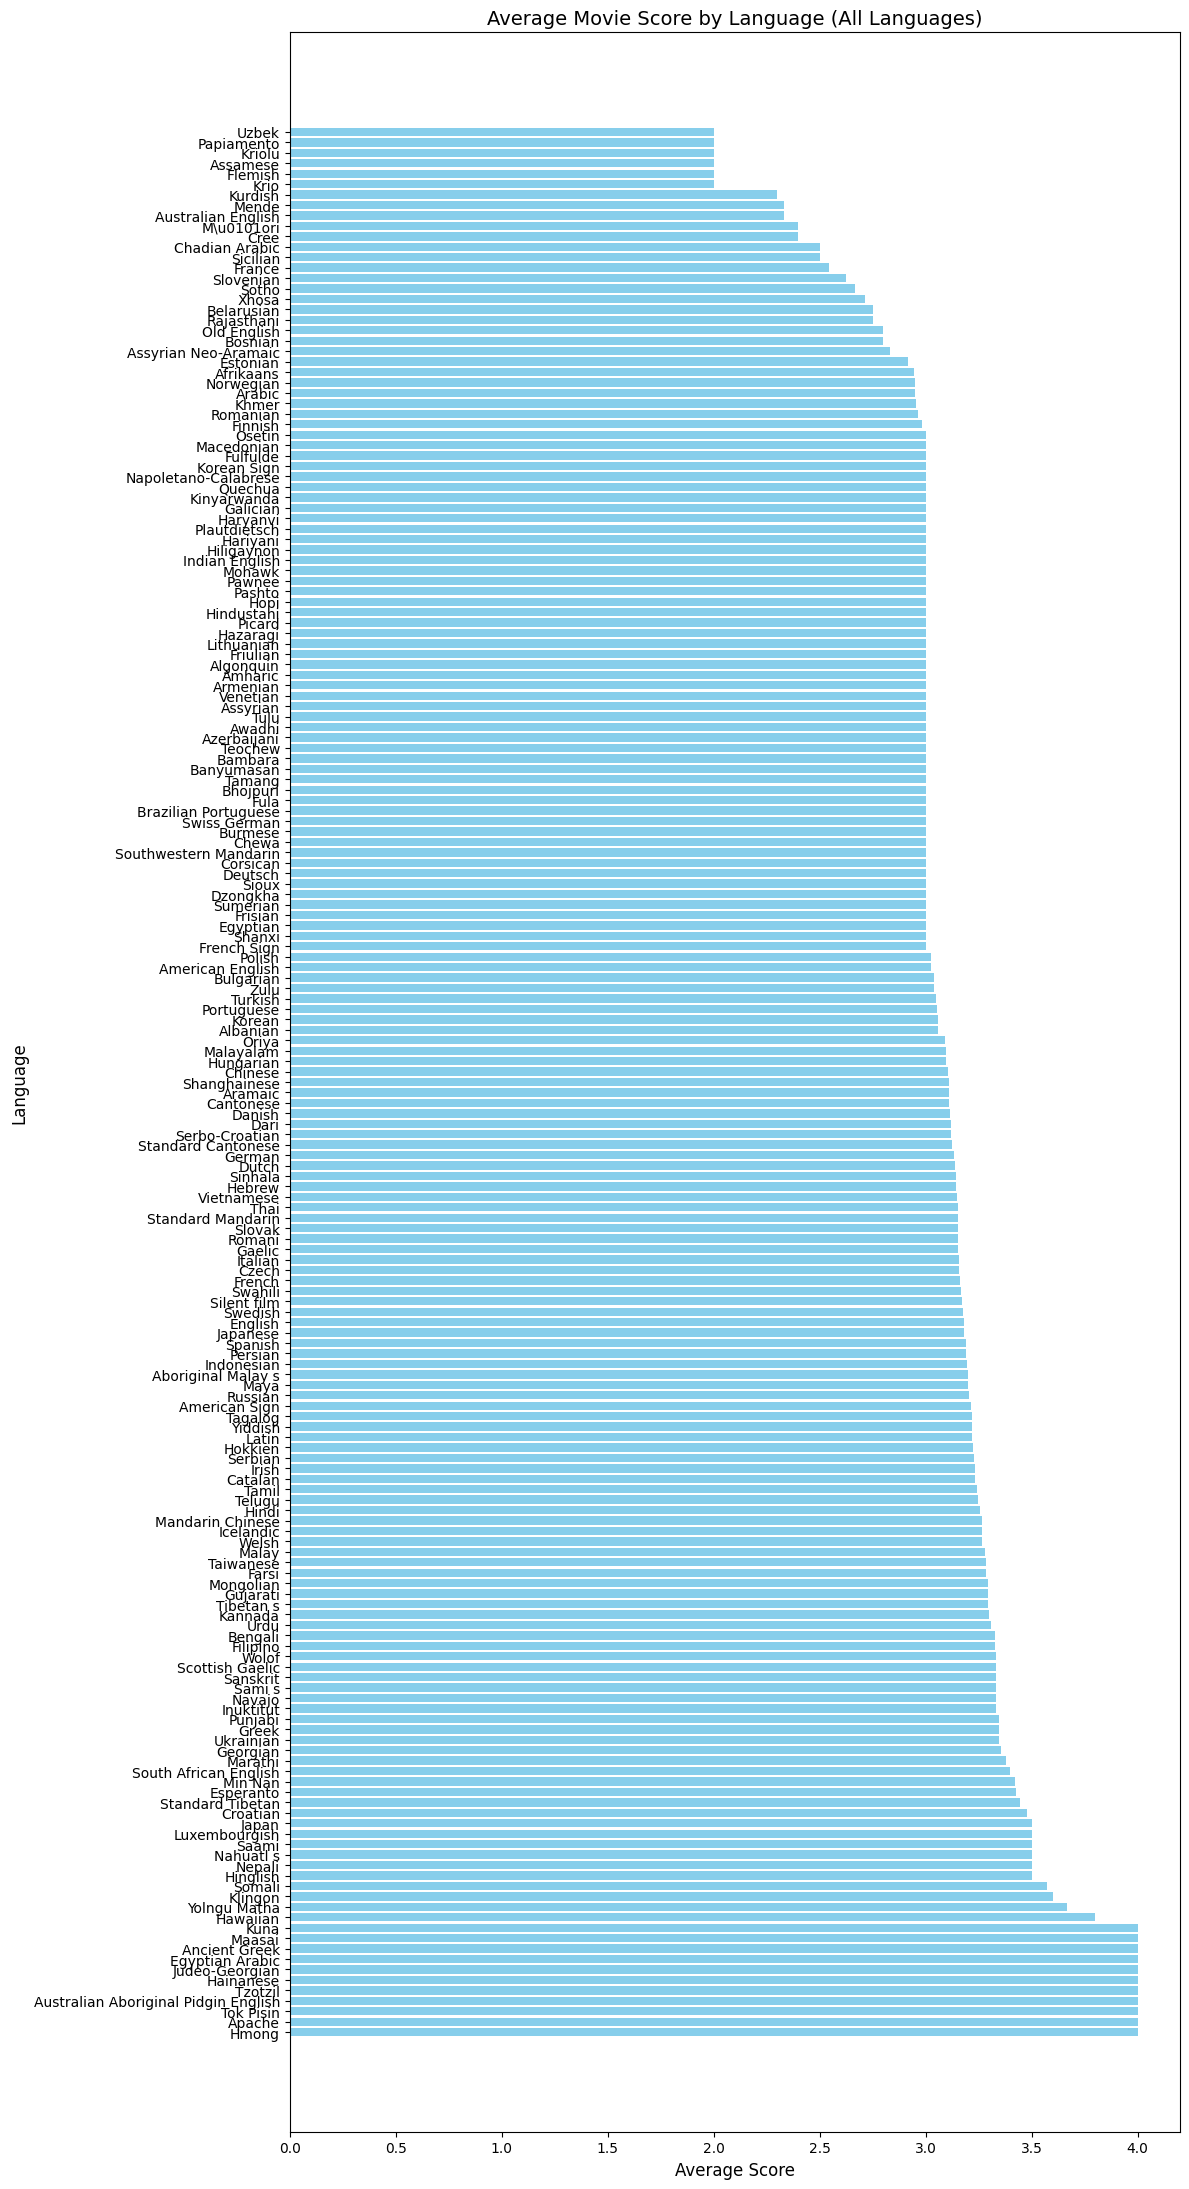

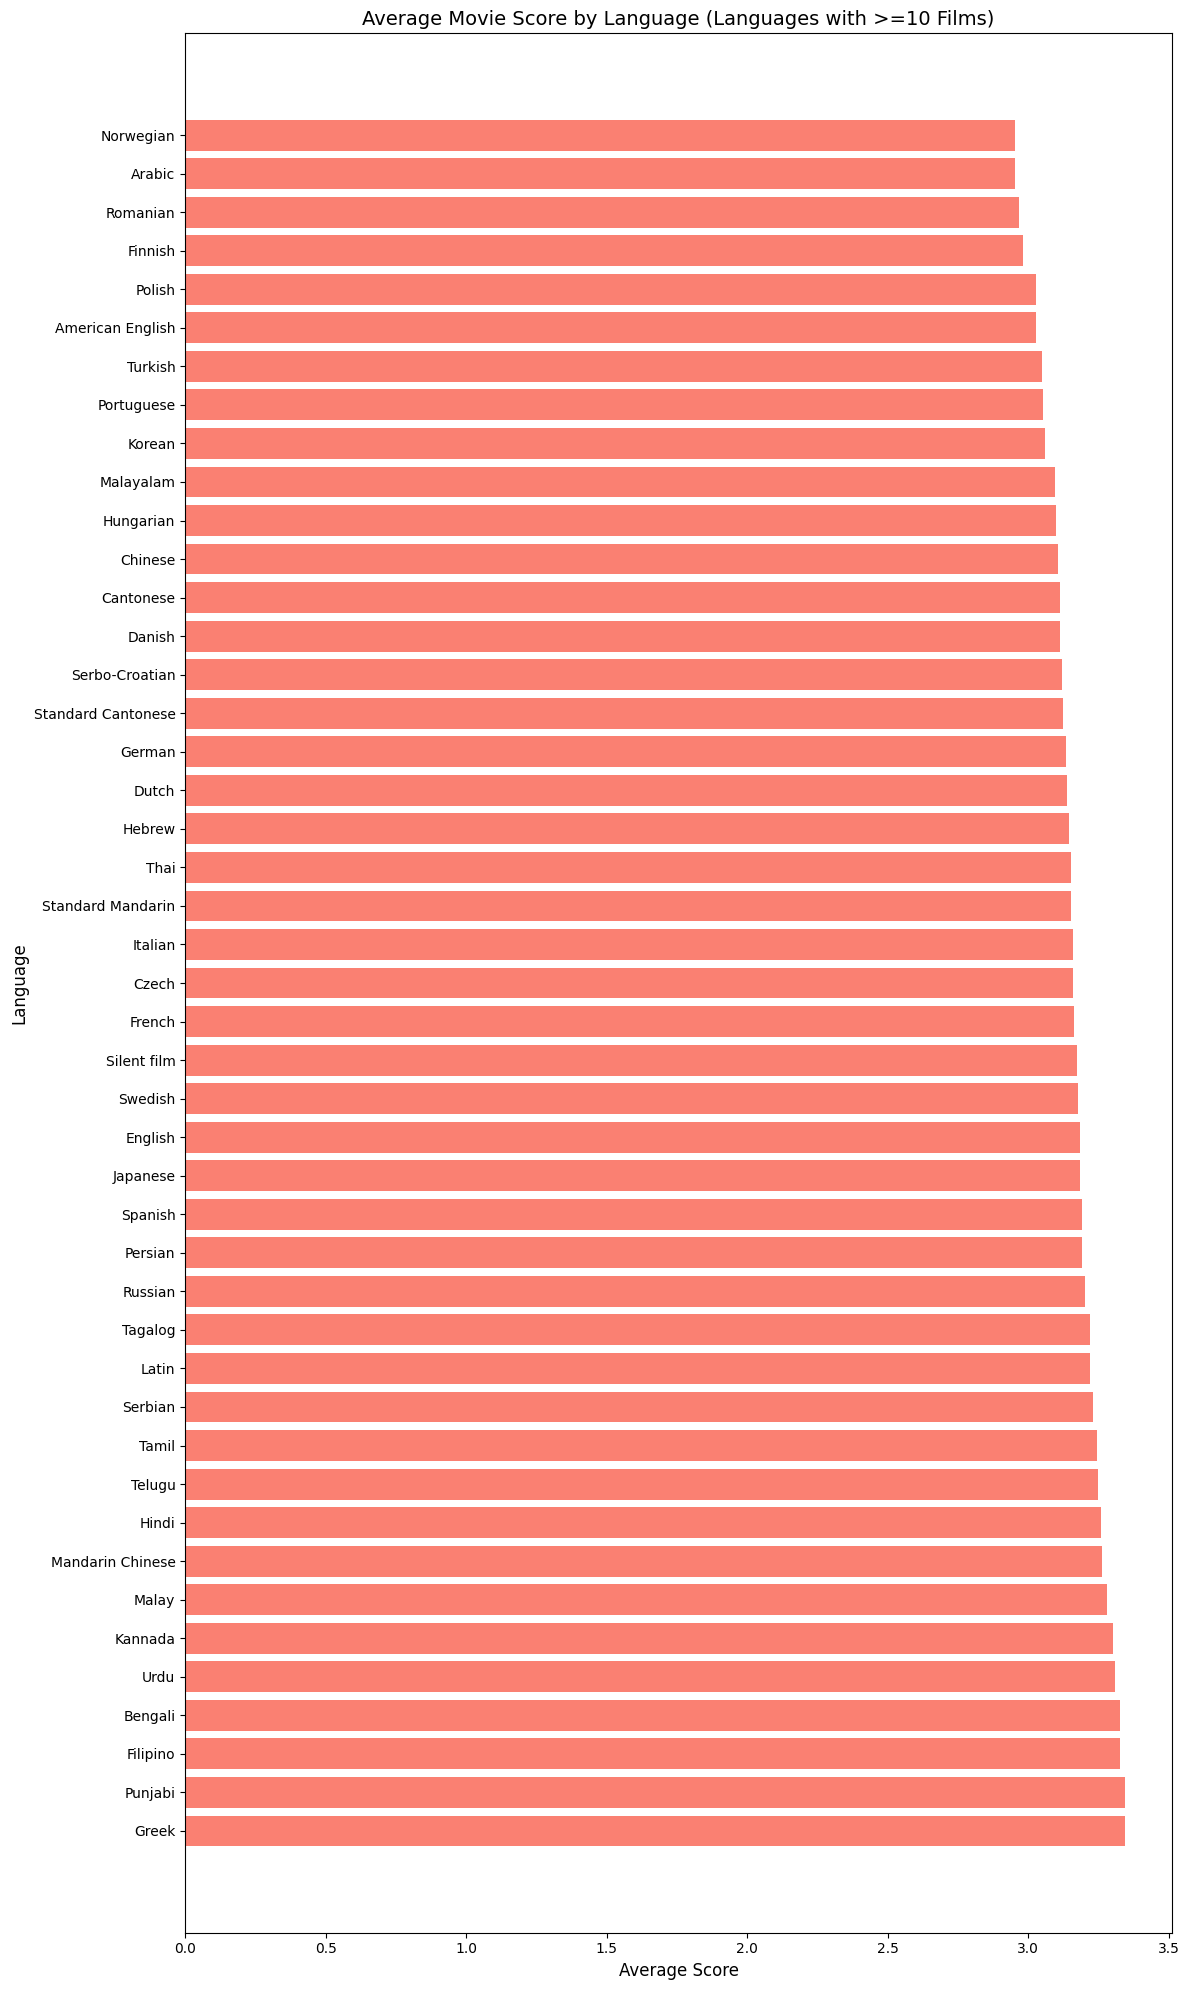

Dataset updated with cleaned 'Languages' column and saved as 'movies_dataset_w_scores.tsv'


In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Helper function to clean up and extract language names
def extract_languages(language_data):
    if pd.isna(language_data) or '{' not in language_data:
        return None
    languages = []
    items = language_data.split(", ")
    for item in items:
        if ':' in item:
            # Clean the language name and remove "Language"/"language"
            language_name = item.split(":")[-1].strip().replace("\"", "").replace("}", "").replace("Language", "").replace("language", "").strip()
            if len(language_name) <= 40:  # Filter out languages longer than 40 characters
                languages.append(language_name)
    return ", ".join(languages) if languages else None

# Apply the function and overwrite the 'Languages' column with cleaned language data
movies_df['Languages'] = movies_df['Languages'].apply(extract_languages)

# Drop rows with missing or invalid language data in 'Languages'
movies_df = movies_df.dropna(subset=['Languages']).copy()

# Explode the 'Languages' column so each language has its own row
exploded_lang_df = movies_df.assign(Languages=movies_df['Languages'].str.split(", ")).explode('Languages')

# Calculate average score and film count per language
language_stats = exploded_lang_df.groupby('Languages').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter to get languages with at least 10 films
language_stats_10_plus = language_stats[language_stats['Film_Count'] >= 50]

# Plot for all languages
plt.figure(figsize=(12, 22))
plt.barh(language_stats.index, language_stats['Average_Score'], color='skyblue')
plt.ylabel('Language', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Language (All Languages)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot for languages with at least 10 films
plt.figure(figsize=(12, 20))
plt.barh(language_stats_10_plus.index, language_stats_10_plus['Average_Score'], color='salmon')
plt.ylabel('Language', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Language (Languages with >=10 Films)', fontsize=14)
plt.tight_layout()
plt.show()

# Save the updated dataset back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)
print("Dataset updated with cleaned 'Languages' column and saved as 'movies_dataset_w_scores.tsv'")


Cleaned dataset saved back to 'movies_dataset_w_scores.tsv'


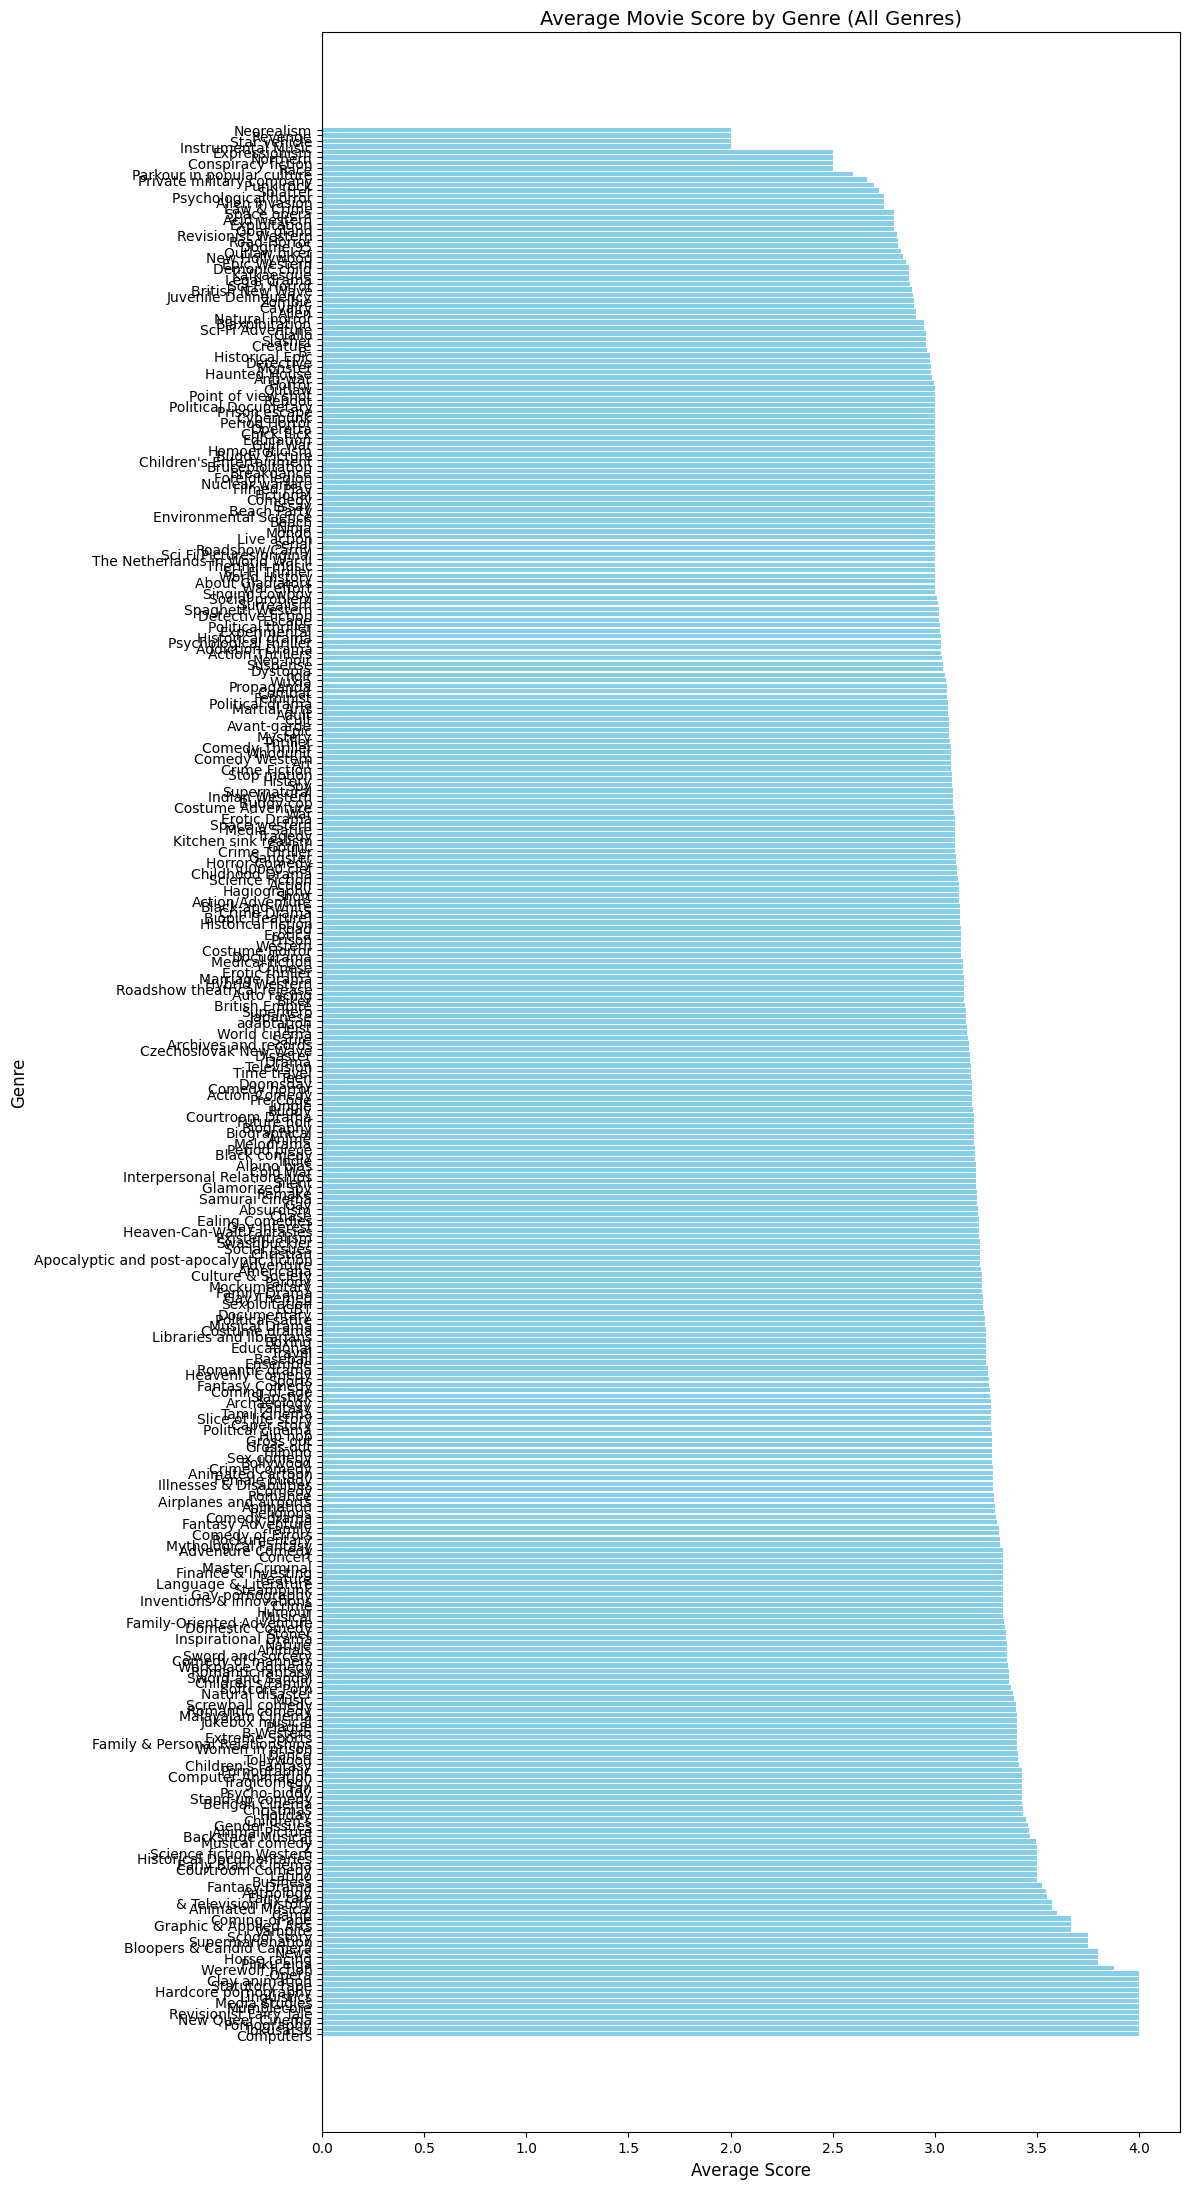

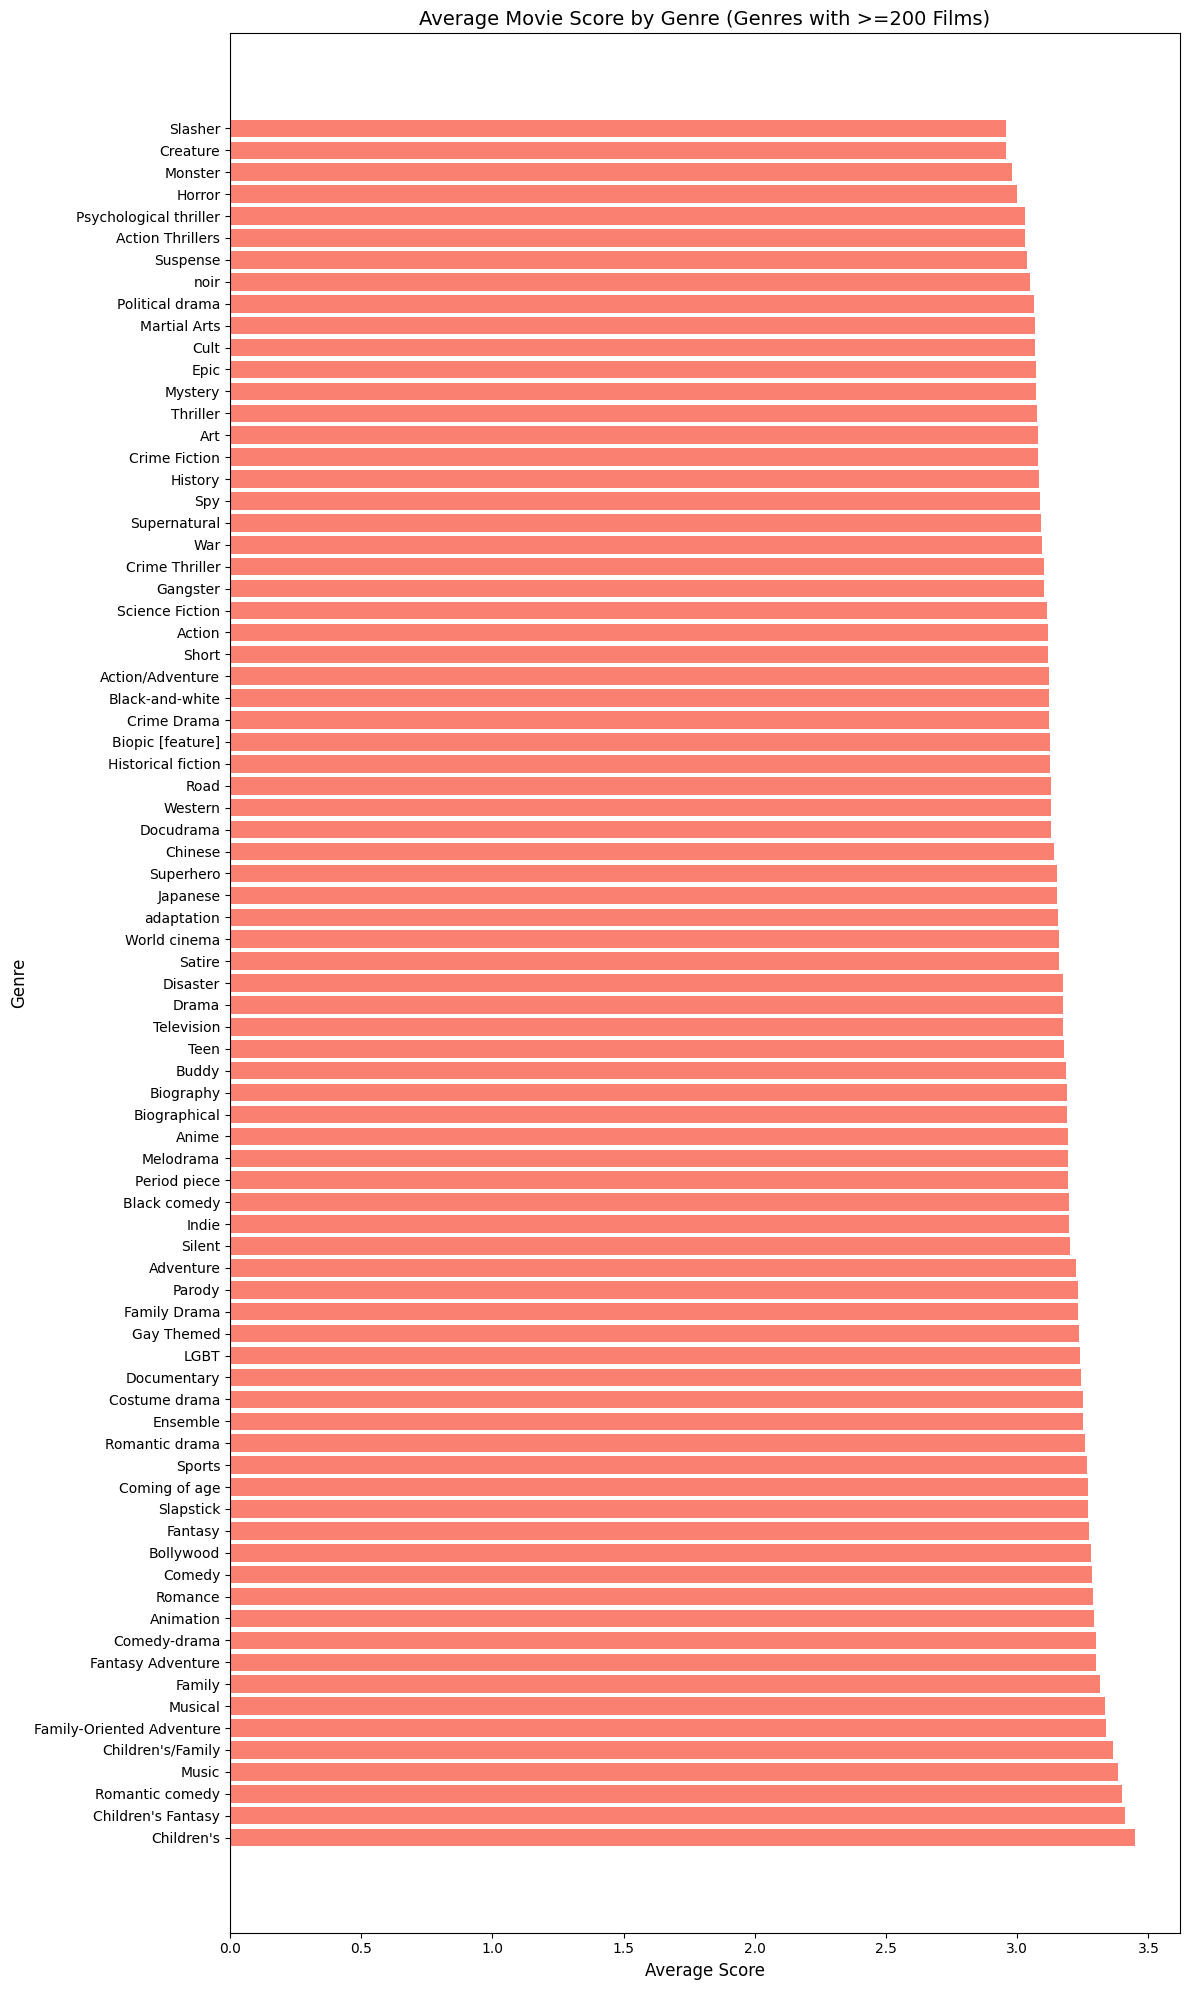

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Helper function to clean and extract genre names
def extract_genres(genre_data):
    if pd.isna(genre_data) or '{' not in genre_data:
        return None
    genres = []
    items = genre_data.split(", ")
    for item in items:
        if ':' in item:
            # Clean the genre name and remove unwanted words
            genre_name = item.split(":")[-1].strip().replace('"', '').replace('}', '')
            # Remove words like "Movie", "Movies", "Film", etc.
            genre_name = re.sub(r'\b(Movie|Movies|Film|Films|movie|movies|film|films)\b', '', genre_name).strip()
            genres.append(genre_name)
    return ", ".join(genres) if genres else None

# Apply the function and overwrite the 'Genres' column with cleaned genre data
movies_df['Genres'] = movies_df['Genres'].apply(extract_genres)

# Drop rows with missing or invalid genre data in 'Genres'
movies_df = movies_df.dropna(subset=['Genres']).copy()

# Save the cleaned dataset with updated 'Genres' column back to the original file
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)
print("Cleaned dataset saved back to 'movies_dataset_w_scores.tsv'")

# Explode the 'Genres' column so each genre has its own row
exploded_genre_df = movies_df.assign(Genres=movies_df['Genres'].str.split(", ")).explode('Genres')

# Calculate the average score and film count per genre
genre_stats = exploded_genre_df.groupby('Genres').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter to get genres with at least 200 films
genre_stats_200_plus = genre_stats[genre_stats['Film_Count'] >= 200]

# Plot for all genres
plt.figure(figsize=(12, 22))
plt.barh(genre_stats.index, genre_stats['Average_Score'], color='skyblue')
plt.ylabel('Genre', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Genre (All Genres)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot for genres with at least 200 films
plt.figure(figsize=(12, 20))
plt.barh(genre_stats_200_plus.index, genre_stats_200_plus['Average_Score'], color='salmon')
plt.ylabel('Genre', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Genre (Genres with >=200 Films)', fontsize=14)
plt.tight_layout()
plt.show()


In [93]:
import pandas as pd
import re

# Load the dataset
movies_df = pd.read_csv('movies_dataset_w_scores.tsv', sep='\t')

# Define a function to extract the 4-digit year from various date formats
def extract_year(date_str):
    # Ensure the date is a string
    date_str = str(date_str)
    
    # Use regex to find a 4-digit year pattern
    match = re.search(r'\b(\d{4})\b', date_str)
    
    if match:
        return match.group(1)  # Return the matched 4-digit year as a string
    else:
        return None  # Return None if no 4-digit year is found

# Apply the function to the 'Release_Date' column to extract only the year
movies_df['Release_Date'] = movies_df['Release_Date'].apply(extract_year)

# Drop rows with no valid year (if needed)
movies_df = movies_df.dropna(subset=['Release_Date'])

# Convert 'Release_Date' to an integer type for any further analysis
movies_df['Release_Date'] = movies_df['Release_Date'].astype(int)

# Save the updated dataset with the cleaned 'Release_Date' column
movies_df.to_csv('movies_dataset_w_scores.tsv', sep='\t', index=False)

print("Dataset updated with cleaned 'Release_Date' years in 'movies_dataset_w_scores.tsv'")


Dataset updated with cleaned 'Release_Date' years in 'movies_dataset_w_scores.tsv'


### Evolution of Average Movie Score Over the Years

This code block analyzes the evolution of average movie scores over time, focusing on years with a substantial number of film releases.

1. **Data Loading**: The code reads `movies_dataset_w_scores.tsv`, which contains movie details and scores.

2. **Grouping by Year**:
   - The dataset is grouped by the `Release_Date` (now cleaned to reflect only the year).
   - For each year, two metrics are calculated:
     - **Average_Score**: The mean score of all movies released that year.
     - **Film_Count**: The total count of movies released that year.

3. **Filtering the Data**:
   - We filter out years where fewer than 100 films were released, focusing only on years with high film activity to ensure reliable average scores.

4. **Plotting**:
   - A line plot displays the evolution of the average movie score over time.
   - The x-axis represents the year, while the y-axis shows the average score.
   - Only years with at least 100 films are shown, providing a clearer view of score trends over time for popular years.

This analysis gives insight into changes in movie scores over time, highlighting how movie quality or scoring trends may have evolved.

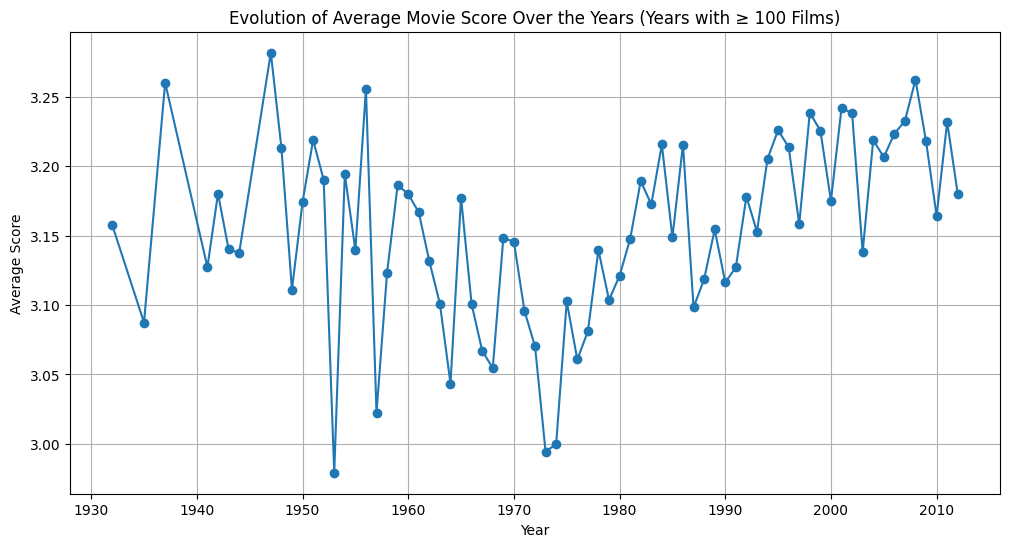

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'movies_dataset_w_scores.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

score_and_count_by_year = movies_df.groupby('Release_Date').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
) 

filtered_data = score_and_count_by_year[score_and_count_by_year['Film_Count'] >= 100]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['Average_Score'], marker='o', linestyle='-')
plt.title('Evolution of Average Movie Score Over the Years (Years with ≥ 100 Films)')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()


### Analysis of Average Movie Score by Country Over Time

This code section processes a dataset of movie scores, extracting and analyzing trends in average movie scores across different countries over the years. The following steps detail the approach and objectives of this analysis:

1. **Dataset Loading**: The dataset is loaded from a TSV file (`movies_dataset_w_scores.tsv`), which includes information about movies, release dates, countries, and scores.

2. **Country Extraction**: To handle countries listed with braces and identifiers, we define the `extract_countries` function. This function isolates the country names by removing any extra formatting characters (like `{}`, identifiers, and quotes). This helps in creating a clean list of countries associated with each movie.

3. **Data Explosion**: Since some movies are associated with multiple countries, we use the `explode` function to create individual rows for each country associated with a film. This allows us to analyze each country separately in the subsequent steps.

4. **Filtering by Yearly Film Count**: We group by country and release date, filtering only the years in which more than 5 movies were released per country. This ensures a more meaningful analysis by focusing on countries with substantial film output per year.

5. **Calculation of Average Scores**: For each country and year, the average movie score is calculated. We also filter to include only countries with at least 10 years of data, providing enough historical context for reliable trend analysis.

6. **Plotting Average Scores by Country**: Finally, for each qualifying country, a separate plot is generated to visualize the trend in average movie scores over the years. This enables us to observe changes in average movie scores within each country over time.

By performing this analysis, we can identify trends and patterns in movie scores across different countries, providing insights into the evolution of movie ratings within each region.


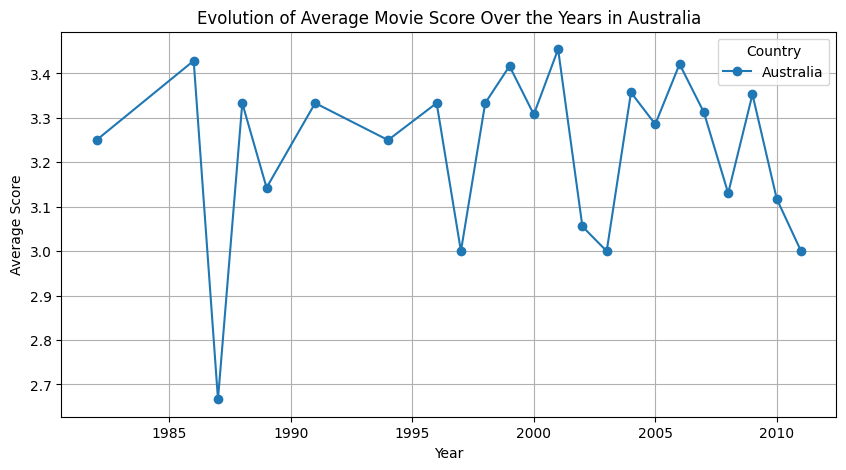

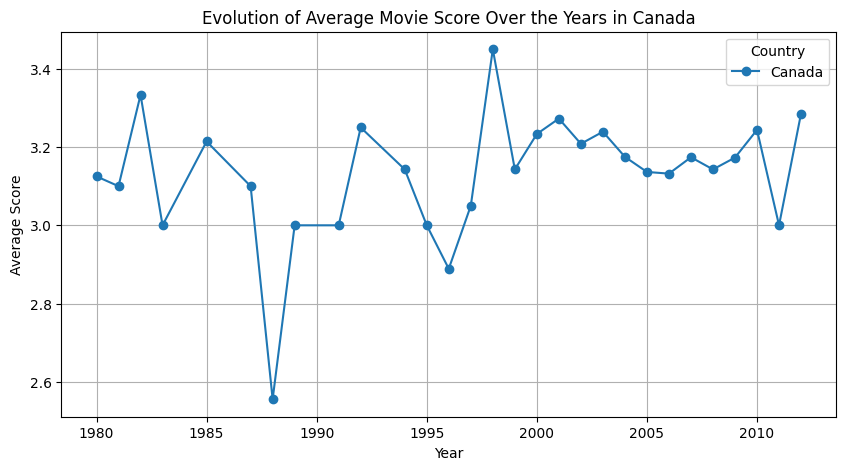

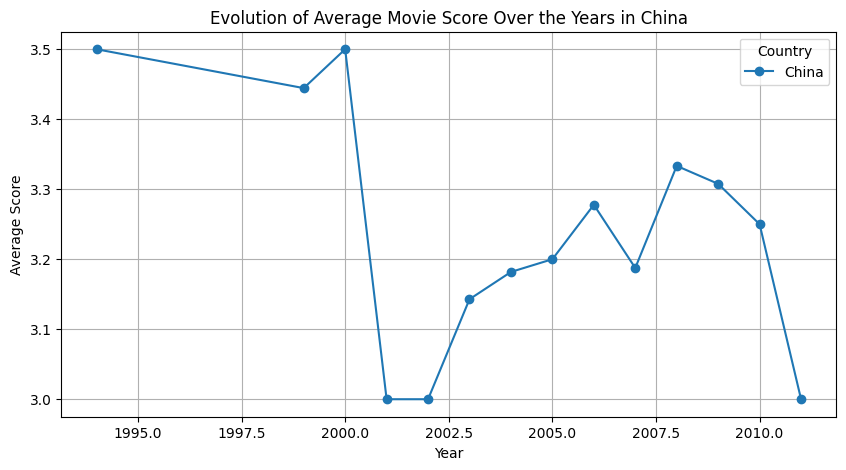

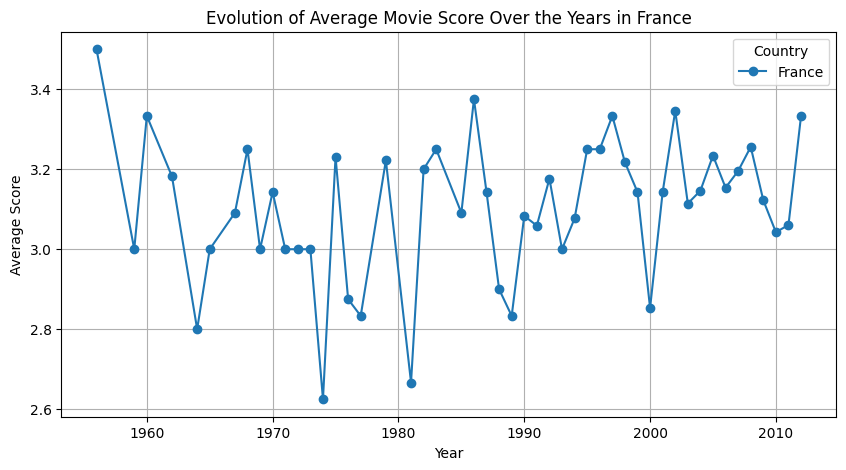

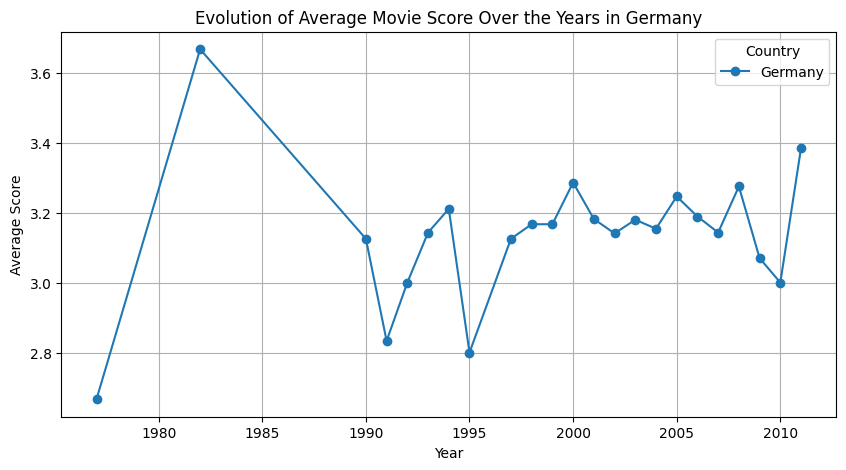

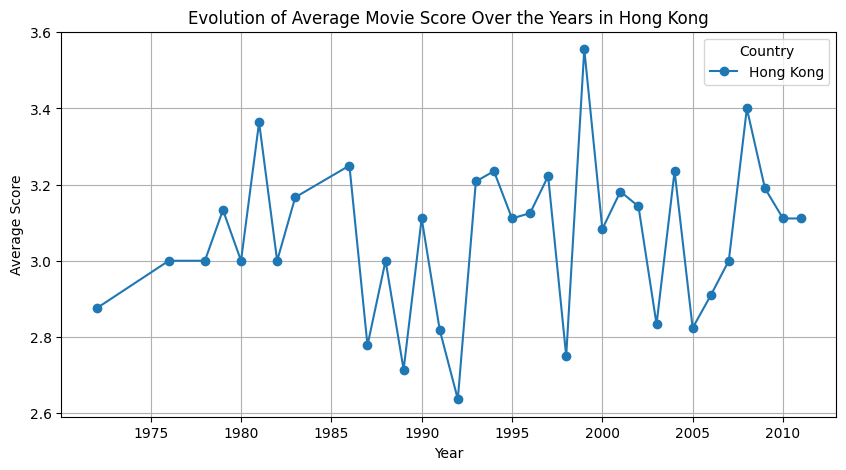

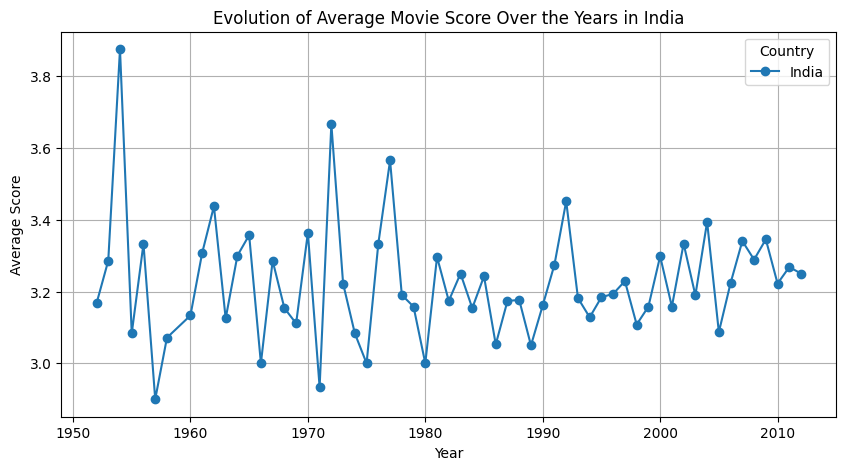

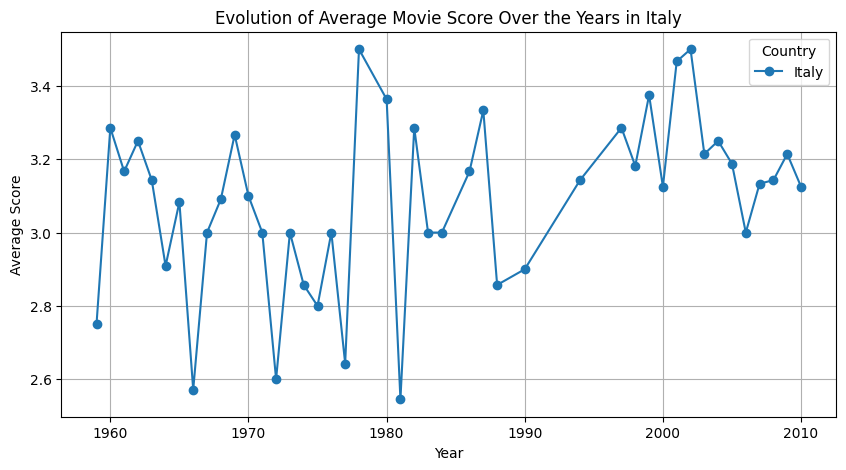

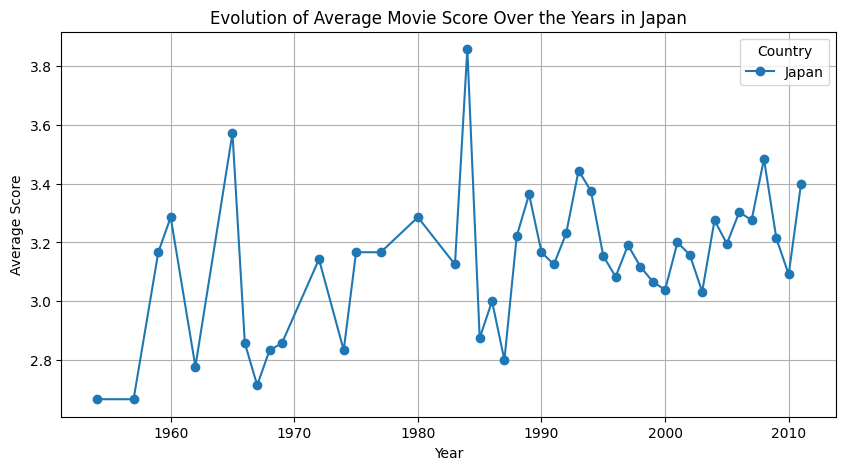

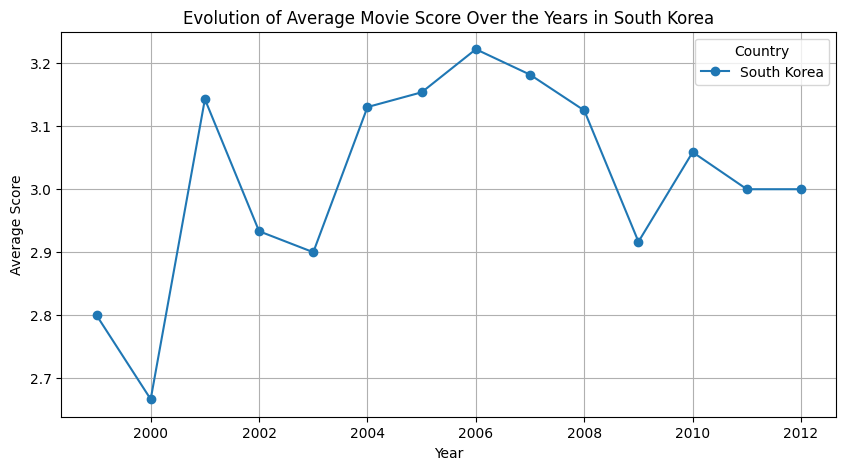

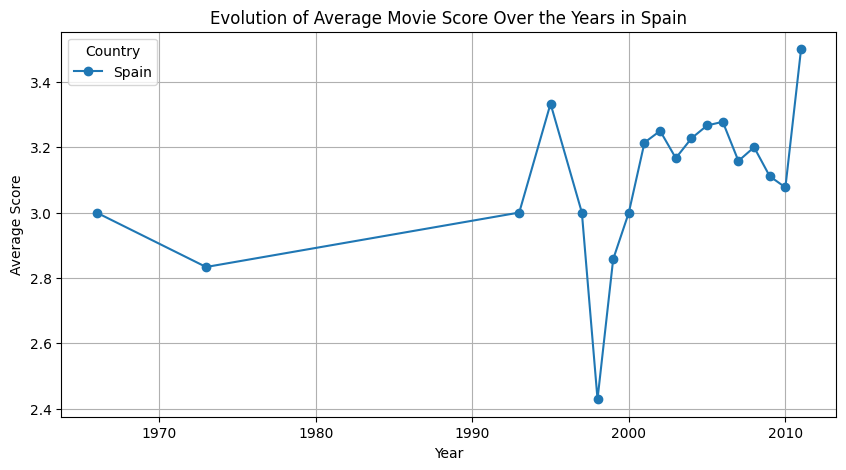

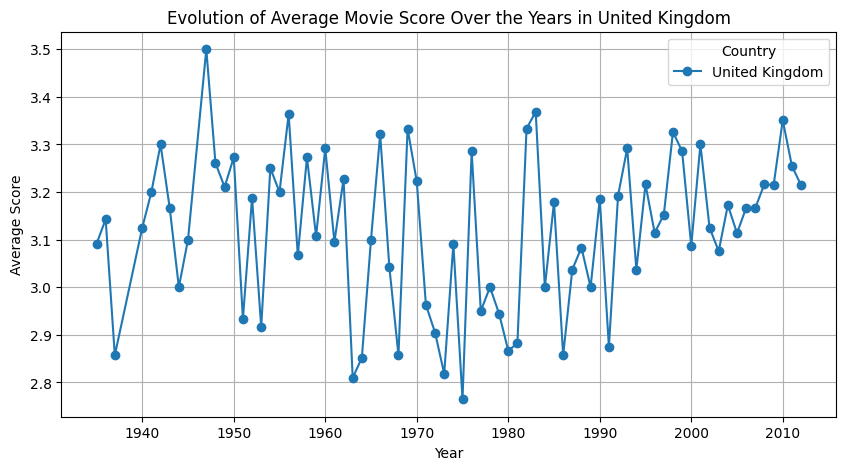

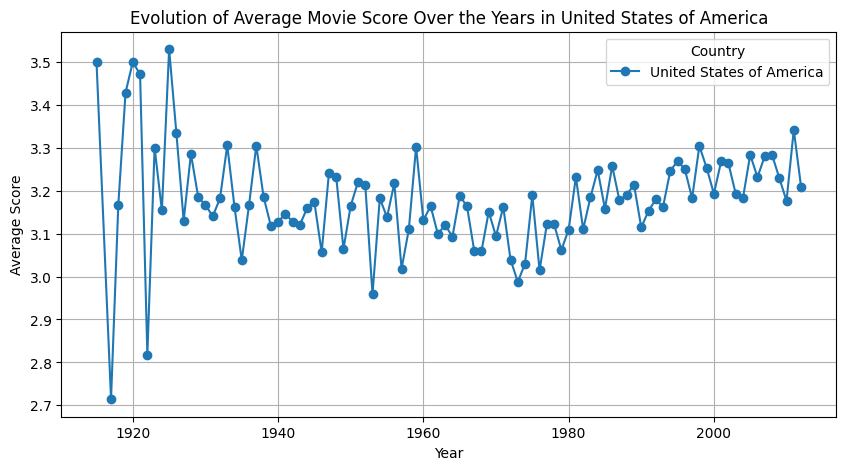

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with years and countries
file_path = 'movies_dataset_w_scores.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

# Function to extract country names by cleaning up braces and identifiers
def extract_countries(country_str):
    if pd.isna(country_str):
        return []
    countries = []
    items = country_str.split(", ")
    for item in items:
        country_name = item.split(":")[-1].strip().replace('"', '').replace('}', '').replace('{', '')
        countries.append(country_name)
    return countries

# Apply the function to separate and clean up country names
movies_df['Country'] = movies_df['Country'].apply(extract_countries)

# Explode rows so that each film is associated with one country at a time
exploded_movies_df = movies_df.explode('Country').dropna(subset=['Country'])

# Filter data for years with more than 10 films per country
films_per_year_country = exploded_movies_df.groupby(['Country', 'Release_Date']).size().reset_index(name='Film_Count')
filtered_countries = films_per_year_country[films_per_year_country['Film_Count'] > 5]

# Merge to keep only rows with enough films per year
filtered_movies_df = exploded_movies_df.merge(filtered_countries[['Country', 'Release_Date']], on=['Country', 'Release_Date'], how='inner')

# Calculate average score by country and year, keeping countries with at least 10 years of data
avg_score_by_country_year = filtered_movies_df.groupby(['Country', 'Release_Date'])['Score'].mean().reset_index()
valid_countries = avg_score_by_country_year['Country'].value_counts()
valid_countries = valid_countries[valid_countries >= 10].index
avg_score_by_country_year = avg_score_by_country_year[avg_score_by_country_year['Country'].isin(valid_countries)]

# Plot the average score trend for each country with sufficient films per year, in separate plots
for country in avg_score_by_country_year['Country'].unique():
    country_data = avg_score_by_country_year[avg_score_by_country_year['Country'] == country]
    
    plt.figure(figsize=(10, 5))
    plt.plot(country_data['Release_Date'], country_data['Score'], marker='o', linestyle='-', label=country)
    plt.title(f'Evolution of Average Movie Score Over the Years in {country}')
    plt.xlabel('Year')
    plt.ylabel('Average Score')
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()


In [ ]:
# 